

# M-Adam: An Effective Variation of the Adam Optimization Algorithm

#### Vincenzo Di Gennaro  
Department of Computer Science, City, University of London
#### Eduardo Alonso  
Artificial Intelligence Research Centre (CitAI), City, University of London


### Summary:

We introduce M-Adam (Maximized-Adaptive Moment Estimation), a variation of the popular Adam optimization algorithm. The method is easy to implement, computationally efficient and well suited for problems with large data and parameters space. The method is particularly appropriate when small initial learning rates are optimal. Empirical results demonstrate that the M-Adam algorithm works well in practice and, most of the time, compares favorably to Adam, RMSprop and other stochastic optimization methods. An advantage is that the same intuition/methodology could be used to enhance other optimization algorithms.

### M-Adam Algorithm

The main idea of M-Adam is that we can add a “super” momentum when we have a situation where the newly calculated gradients are in the same direction as the current gradients momentum and have also a bigger absolute size. Therefore, we have the advantage created by the momentum which is “jumping” through local minima areas in the loss functions and, at the same time, add acceleration when the newly calculated gradients are in the same direction of the momentum and their absolute size is bigger. In this way, we avoid unnecessary “slowdowns” from the accumulated exponential moving averages of the gradients. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.io import loadmat  
from datetime import datetime, date, time
%matplotlib inline

#### Useful functions to be used later for the tasks

In [2]:
import time
from IPython.display import display, clear_output
from scipy.special import expit
from scipy.stats import truncnorm
from util_func import *
from sklearn.metrics import mean_squared_error

#### M-adam: optimization algorithm

### Implementation

In [3]:

class NN_madam():
    
    def __init__(self, size_h_layer, l_rate, l_decay=None, initialization='he', 
                 activation_h='ReLU', activation_o= 'sigmoid', l2_reg=None,
                 dropout = (None, (0,0.25)), bias=1, 
                 optimizer=('momentum',{'beta1':0.9, 'beta2':0.999}),
                plots=True, print_=True):
        """
        X has to have shape (#samples, #features)
        y has to have shape (#samples, 1)
        """
        
        self.size_h_layer = size_h_layer 
        self.activation_h = activation_h
        self.activation_o = activation_o
        self.l_rate = l_rate
        self.l_decay = l_decay
        self.initialization = initialization
        self.l2_reg = l2_reg
        self.dropout = dropout
        self.bias = bias
        self.optimizer = optimizer
        self.print_ = print_
        self.plots = plots
        
        if self.activation_h == 'ReLU': 
            self.activation_function = ReLU
            self.derivative_func = ReLU_derivation
        if self.activation_h == 'LeakyReLU': 
            self.activation_function = LeakyReLU
            self.derivative_func = LReLU_deriv
        if self.activation_h == 'sigmoid': 
            self.activation_function = sigmoid    
            self.derivative_func = sigmoid_der
        
        self.initialize_params()
        
        if self.optimizer[0]=='momentum':
            self.initialize_v()
        if self.optimizer[0]=='RMSprop':
            self.initialize_s()
        if self.optimizer[0]=='adam':
            self.initialize_v()
            self.initialize_s()
        if self.optimizer[0]=='madam':
            self.initialize_v()
            self.initialize_s()
            
        if self.l_decay:
            self.initial_l_rate = self.l_rate
    
    
    #--------------------------------------------------------------------------------------
    def initialize_params(self):
        bias_node = 1 if self.bias else 0
        self.Ws = {}
        self.Bs = {}
        for l in range(1,len(self.size_h_layer)):            
            if self.bias:
                if self.initialization == 'truncnorm':
                    rad = 1 / np.sqrt(self.size_h_layer[l])
                    N = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
                    self.Ws['W_'+str(l)] = N.rvs((self.size_h_layer[l], self.size_h_layer[l-1]))
                    self.Bs['b_'+str(l)] = N.rvs((self.size_h_layer[l],1))
                if self.initialization == 'he':
                    self.Ws['W_'+str(l)] = np.random.randn(self.size_h_layer[l], self.size_h_layer[l-1]) * np.sqrt(2/self.size_h_layer[l-1])
                    self.Bs['b_'+str(l)] = np.random.randn(self.size_h_layer[l],1) * np.sqrt(2/self.size_h_layer[l-1])
            
            else:
                if self.initialization == 'truncnorm':
                    rad = 1 / np.sqrt(self.size_h_layer[l])
                    N = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
                    self.Ws['W_'+str(l)] = N.rvs((self.size_h_layer[l], 
                                           self.size_h_layer[l-1]))
                if self.initialization == 'he':
                    self.Ws['W_'+str(l)] = np.random.randn(self.size_h_layer[l], self.size_h_layer[l-1]) * np.sqrt(6/self.size_h_layer[l-1])
                    
    #--------------------------------------------------------------------------------------            
    def initialize_v(self):
        L = len(self.Ws)
        self.v = {}
        for l in range(L):
            self.v['vdW_'+str(l+1)] = np.zeros(self.Ws['W_'+str(l+1)].shape)
            if self.bias:
                self.v['vdB_'+str(l+1)] = np.zeros(self.Bs['b_'+str(l+1)].shape)
    #--------------------------------------------------------------------------------------
    def initialize_s(self):
        L = len(self.Ws)
        self.s = {}
        for l in range(L):
            self.s['sdW_'+str(l+1)] = np.zeros(self.Ws['W_'+str(l+1)].shape)
            if self.bias:
                self.s['sdB_'+str(l+1)] = np.zeros(self.Bs['b_'+str(l+1)].shape)
            
            
            
    #--------------------------------------------------------------------------------------   
    def fwd_prop(self, input_vect, dropout_on=1):
        self.z = {}
        self.a = {}
        self.d = {}
        
        if self.bias: adjust_bias = 1
        else: adjust_bias = 0
            
        for l in range(1,len(self.size_h_layer)):
            
            if l == 1: # input layer 
                    
                self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(input_vect.T) + self.Bs['b_'+str(l)]*adjust_bias 
                self.a['a_'+str(l)] = self.activation_function(self.z['z_'+str(l)] )    
                if self.dropout[0] and dropout_on:
                    d = np.random.rand(*self.a['a_'+str(l)].shape)
                    self.d['d_'+str(l)] = 1 * (d > self.dropout[1][l])
                    self.a['a_'+str(l)] *= self.d['d_'+str(l)]
                    self.a['a_'+str(l)] /= (1-self.dropout[1][l])
                    
            elif (l > 1) and (l < len(self.size_h_layer)-1): 
                self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                self.a['a_'+str(l)] = self.activation_function(self.z['z_'+str(l)])
                if self.dropout[0] and dropout_on:
                    d = np.random.rand(*self.a['a_'+str(l)].shape)
                    self.d['d_'+str(l)] = 1 * (d > self.dropout[1][l])
                    self.a['a_'+str(l)] *= self.d['d_'+str(l)]
                    self.a['a_'+str(l)] /= (1-self.dropout[1][l])
                    
            elif l == len(self.size_h_layer)-1: 
                if self.activation_o == 'sigmoid':                    
                    self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                    self.a['a_'+str(l)] = sigmoid(self.z['z_'+str(l)])
                if self.activation_o == 'softmax':
                    self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                    self.a['a_'+str(l)] = softmax(self.z['z_'+str(l)])
                if self.activation_o == 'linear':
                    self.z['z_'+str(l)] = self.Ws['W_'+str(l)].dot(self.a['a_'+str(l-1)]) + self.Bs['b_'+str(l)]*adjust_bias 
                    self.a['a_'+str(l)] = self.z['z_'+str(l)]
                    
        return self.a['a_'+str(l)]
        
        
        
    #--------------------------------------------------------------------------------------
    def J_cost(self, y, output):
        m = y.shape[0]
        if self.activation_o == 'sigmoid':
            y_enc = y.T
        elif self.activation_o == 'softmax':
            #y.shape = (#samples, class)
            y_enc = encode_labels(y, self.size_h_layer[-1])
        elif self.activation_o == 'linear':
            y_enc = y.T
        if self.l2_reg:
            reg = 0
            for k in self.Ws.keys():
                reg = reg + (self.Ws[k].T@self.Ws[k]).sum().sum()
            reg = (1/m) * self.l2_reg/2 * reg
        else: reg = 0
            
        if self.activation_o == 'sigmoid':
            cost_ = -(1/m) * (y_enc * (np.log(output)) + (1.0 - y_enc) * np.log(1.0 - output)) + reg
        if self.activation_o == 'softmax':
            cost_ = -(1/m) * (y_enc * (np.log(output))) + reg
        if self.activation_o == 'linear':
            cost_ = 0.5 * (1/m) * np.square(y_enc - output) + reg
        
        cost = np.sum(cost_)   
                           
        return cost
    
    
    
    #--------------------------------------------------------------------------------------
    def optimize_grads(self, layer):
        l = layer
        if self.optimizer[0]=='momentum':
            beta1 = self.optimizer[1]['beta1']
            self.v['vdW_'+str(l)] = beta1 * self.v['vdW_'+str(l)] + (1-beta1)*self.dW['dw_'+str(l)]
            if self.bias:
                self.v['vdB_'+str(l)] = beta1*self.v['vdB_'+str(l)] + (1-beta1)*self.dB['db_'+str(l)]
        
        if self.optimizer[0]=='RMSprop':
            beta2 = self.optimizer[1]['beta2']            
            self.s['sdW_'+str(l)] = beta2*self.s['sdW_'+str(l)] + (1-beta2)*np.square(self.dW['dw_'+str(l)])
            if self.bias:
                self.s['sdB_'+str(l)] = beta2*self.s['sdB_'+str(l)] + (1-beta2)*np.square(self.dB['db_'+str(l)])
                
                
        if self.optimizer[0]=='adam':
            beta1 = self.optimizer[1]['beta1']
            beta2 = self.optimizer[1]['beta2']
            self.v['vdW_'+str(l)] = beta1*self.v['vdW_'+str(l)] + (1-beta1)*self.dW['dw_'+str(l)]
            self.s['sdW_'+str(l)] = beta2*self.s['sdW_'+str(l)] + (1-beta2)*np.square(self.dW['dw_'+str(l)])
            #self.v['vdW_'+str(l)] /= (1-np.power(beta1,self.t))
            #self.s['sdW_'+str(l)] /= (1-np.power(beta2,self.t))            
            
            if self.bias:
                self.v['vdB_'+str(l)] = beta1*self.v['vdB_'+str(l)] + (1-beta1)*self.dB['db_'+str(l)]
                self.s['sdB_'+str(l)] = beta2*self.s['sdB_'+str(l)] + (1-beta2)*np.square(self.dB['db_'+str(l)])
        
        if self.optimizer[0]=='madam':
            beta1 = self.optimizer[1]['beta1']
            beta2 = self.optimizer[1]['beta2']
            self.v['vdW_'+str(l)] = (beta1*self.v['vdW_'+str(l)] + (1-beta1)*self.dW['dw_'+str(l)])
            self.s['sdW_'+str(l)] = beta2*self.s['sdW_'+str(l)] + (1-beta2)*np.square(self.dW['dw_'+str(l)])
            #self.v['vdW_'+str(l)] /= (1-np.power(beta1,self.t))
            #self.s['sdW_'+str(l)] /= (1-np.power(beta2,self.t)) 
            if self.bias:
                self.v['vdB_'+str(l)] = beta1*self.v['vdB_'+str(l)] + (1-beta1)*self.dB['db_'+str(l)]
                self.s['sdB_'+str(l)] = beta2*self.s['sdB_'+str(l)] + (1-beta2)*np.square(self.dB['db_'+str(l)])
         
        
                
    #--------------------------------------------------------------------------------------            
    def back_prop(self, input_vect, y):
       
        assert(y.shape[1]==1)
        
        m = input_vect.shape[0]
        
        self.sigmas = {}
        self.dZ = {}
        self.dW = {}
        self.dB = {}
        
        if self.size_h_layer[-1]>1:
            y = encode_labels(y,self.size_h_layer[-1]) 
        else: y = y.T
            
        # last layer
        output = self.fwd_prop(input_vect)        
        l = len(self.size_h_layer)-1  
        
        
        #last layer error
        self.sigmas['sigma_'+str(l)] = output - y
        if self.l2_reg:
            add_reg = self.l2_reg/m * self.Ws['W_'+str(l)]
        else: add_reg = 0
            
        #last weights grads
        self.dW['dw_'+str(l)] = (1 / m) * np.dot(self.sigmas['sigma_'+str(l)], self.a['a_'+str(l-1)].T) + add_reg            
        
        if self.bias:
            self.dB['db_'+str(l)] = (1 / m) * np.sum(self.sigmas['sigma_'+str(l)], axis=1, keepdims=True) 
            
        if self.optimizer[0] != None:
            self.optimize_grads(layer=l)
        
                
        # hidden layer back prop
        for l in reversed(range(1, len(self.size_h_layer)-1)): #reverse loop through layer excluding the 1st
            if self.dropout[0]:
                drop_adj = self.Ws['W_'+str(l+1)].T.dot(self.sigmas['sigma_'+str(l+1)]) * self.d['d_'+str(l)]
                #inverted dropout adjustments
                drop_adj /= (1-self.dropout[1][l])
                self.sigmas['sigma_'+str(l)] = drop_adj * self.derivative_func(self.z['z_'+str(l)])
            else:
                self.sigmas['sigma_'+str(l)] = self.Ws['W_'+str(l+1)].T.dot(self.sigmas['sigma_'+str(l+1)]) * self.derivative_func(self.z['z_'+str(l)])                        
            if self.l2_reg:
                add_reg = self.l2_reg/m * self.Ws['W_'+str(l)]
            else: add_reg = 0 
            #gradients
            if l == 1:                
                self.dW['dw_'+str(l)] = (1 / m) * np.dot(self.sigmas['sigma_'+str(l)], input_vect) + add_reg
            else:
                self.dW['dw_'+str(l)] = (1 / m) * np.dot(self.sigmas['sigma_'+str(l)], self.a['a_'+str(l-1)].T) 
            
            if self.bias:
                self.dB['db_'+str(l)] = (1 / m) * np.sum(self.sigmas['sigma_'+str(l)], axis=1, keepdims=True)
                
            if self.optimizer[0] != None:
                self.optimize_grads(layer=l)
            
            
            
    #--------------------------------------------------------------------------------------    
    def updates(self):
        for l in range(1,len(self.Ws)+1):
            if self.optimizer[0] == 'momentum':
                self.Ws['W_'+str(l)] -= self.l_rate * self.v['vdW_'+str(l)]#/(1-self.optimizer[1]['beta1']**t)
                self.Bs['b_'+str(l)] -= self.l_rate * self.v['vdB_'+str(l)]#/(1-self.optimizer[1]['beta1']**t)
            if self.optimizer[0] == 'RMSprop':
                self.Ws['W_'+str(l)] -= self.l_rate * self.dW['dw_'+str(l)] / (np.sqrt(self.s['sdW_'+str(l)]) + 1e-07)#/(1-self.optimizer[1]['beta2']**t))
                self.Bs['b_'+str(l)] -= self.l_rate * self.dB['db_'+str(l)] / (np.sqrt(self.s['sdB_'+str(l)]) + 1e-07)#/(1-self.optimizer[1]['beta2']**t))
            if self.optimizer[0] == 'adam':              
                self.Ws['W_'+str(l)] -= self.l_rate * self.v['vdW_'+str(l)] / (np.sqrt(self.s['sdW_'+str(l)]) + 1e-07)# /(1-self.optimizer[1]['beta1']**t)
                self.Bs['b_'+str(l)] -= self.l_rate * self.v['vdB_'+str(l)] / (np.sqrt(self.s['sdB_'+str(l)]) + 1e-07)# /(1-self.optimizer[1]['beta1']**t)
    
    #----------------------------------------------------#
    #--------------- M-Adam Adjustments -----------------#
    #----------------------------------------------------#
    
            if self.optimizer[0] == 'madam':
                # madam momentum adjustment for the update of the weights
                mask = (np.sign(self.dW['dw_'+str(l)])==np.sign(self.v['vdW_'+str(l)])) & \
                       (np.abs(self.dW['dw_'+str(l)]) > np.abs(self.v['vdW_'+str(l)]))
                    
                max_grads = np.where(mask==False,self.v['vdW_'+str(l)],self.dW['dw_'+str(l)])                    
                
                self.Ws['W_'+str(l)] -= self.l_rate * max_grads / (np.sqrt(self.s['sdW_'+str(l)]) + 1e-07)
                self.Bs['b_'+str(l)] -= self.l_rate * self.dB['db_'+str(l)] / (np.sqrt(self.s['sdB_'+str(l)]) + 1e-07)              
                
            else:
                self.Ws['W_'+str(l)] -= self.l_rate * self.dW['dw_'+str(l)] 
                self.Bs['b_'+str(l)] -= self.l_rate * self.dB['db_'+str(l)]
                
                
    
    #--------------------------------------------------------------------------------------
    def predict(self,X):
        pred = self.fwd_prop(X, dropout_on=0)
        if self.activation_o=='softmax':
            pred = np.argmax(pred, axis=0).reshape(-1,1)
        if self.activation_o=='sigmoid':
            pred = np.where(pred>0.5,1,0).reshape(-1,1)
        if self.activation_o=='linear':
            pred = pred.reshape(-1,1)
        else:
            pred = pred
        return pred
    
    
    
    #--------------------------------------------------------------------------------------
    def train_nn(self, X_train, y_train, epochs=10, nr_shuffles=1, batch_size=32, cval=None, early_stopping=(None, {'epochs':20}), grads_stopping= False):
            
        for r in range(nr_shuffles):    
            self.t = 1.0
            m = X_train.shape[0]
            assert(y_train.shape[1]==1)
            assert(X_train.shape[0] == y_train.shape[0])

            if cval!=None:   
                #reshuffle training set
                data = np.hstack([X_train, y_train])
                np.random.shuffle(data)

                val_data = np.round(cval*m,0).astype(int)
                X_val = data[:val_data,:-1]
                y_val = data[:val_data,-1].reshape(-1,1).astype(int)

                X_train_ = data[val_data:,:-1]
                y_train_ = data[val_data:,-1].reshape(-1,1).astype(int)

            else:
                X_train_ = X_train.copy()
                y_train_ = y_train.copy()

            validation_accuracy = []
            training_accuracy = []
            validation_cost = []
            self.training_cost = []
            self.tr_batch_cost = []
            self.val_batch_cost = []
            self.gradient_sizes = []

            #initial cost and accuracy
            train_output = self.fwd_prop(input_vect=X_train_)
            initial_cost = np.round(self.J_cost(y=y_train_, output=train_output),4)

            if self.activation_o == 'softmax':
                initial_acc = np.round((np.argmax(train_output, axis=0).reshape(-1,1)==y_train_).mean(),4)
            elif self.activation_o =='sigmoid':
                initial_acc = (np.where(train_output>0.5,1,0) == y_train_.reshape(1,-1)).mean()
            elif self.activation_o =='linear':
                initial_acc = np.sqrt(np.square(train_output - y_train_.reshape(1,-1))).sum()/y_train_.mean()
            else:
                pass
            if self.print_!=None:
                print('initial_cost: ',initial_cost, ' initial_acc: ',initial_acc)

            # epochs run
            for e in range(epochs):
                m = X_train_.shape[0]
                data = np.hstack([X_train_, y_train_])
                np.random.shuffle(data)
                X_train_ = data[:,:-1]
                y_train_ = data[:,-1].reshape(-1,1).astype(int)

                if batch_size!= None:
                    n_batches = m // batch_size
                else:
                    n_batches = 1 
                    batch_size = m
                batches = np.array_split(np.arange(m), n_batches)


                for i, b in enumerate(batches):
                    X_ = X_train_[b,:] 
                    y_ = y_train_[b,:]  
                    self.back_prop(input_vect=X_, y=y_)
                    self.updates()
                    self.t +=1
                    wait = "progress: " + str(np.round(np.round(i/len(batches),2)*100,0))+'%'
                    print (wait, end="\r")
                    
                    if i%25==0:
                        train_output = self.fwd_prop(input_vect=X_, dropout_on=0)
                        self.train_cost = np.round(self.J_cost(y=y_, output=train_output),4)
                        self.tr_batch_cost.append(self.train_cost)
                        if cval!= None:
                            val_samples = np.random.choice(X_val.shape[0],np.minimum(batch_size,X_val.shape[0]))
                            val_output = self.fwd_prop(input_vect=X_val[val_samples], dropout_on=0)
                            val_cost = np.round(self.J_cost(y=y_val[val_samples], output=val_output),4)
                            self.val_batch_cost.append(val_cost)

                if batch_size==None or batch_size==m:
                    train_output = self.fwd_prop(input_vect=X_, dropout_on=0)
                    self.train_cost = np.round(self.J_cost(y=y_, output=train_output),6)
                    self.tr_batch_cost.append(train_cost)
                    if cval!= None:
                        val_samples = np.random.choice(X_val.shape[0],np.minimum(batch_size,X_val.shape[0]))
                        val_output = self.fwd_prop(input_vect=X_val[val_samples], dropout_on=0)
                        val_cost = np.round(self.J_cost(y=y_val[val_samples], output=val_output),4)
                        self.val_batch_cost.append(val_cost)


                # update learning rate with decay
                if self.l_decay:
                    self.l_rate = self.initial_l_rate * self.l_decay**e

                # calculating improvements at the end of each epoch
                train_output = self.fwd_prop(input_vect=X_train_, dropout_on=0)
                if self.activation_o == 'softmax':    
                    train_acc = np.round((np.argmax(train_output, axis=0).reshape(-1,1)==y_train_).mean(),4)
                elif self.activation_o == 'sigmoid':
                    train_acc = np.round((np.where(train_output>0.5,1,0) == y_train_.T).mean(),4)
                elif self.activation_o =='linear':
                    train_acc = np.sqrt(np.square(train_output - y_train_.reshape(1,-1))).mean()/y_train_.mean()
                training_accuracy.append(train_acc)

                if cval: 
                    val_output = self.fwd_prop(input_vect=X_val, dropout_on=0) # switch off the dropout in validation test    
                if cval:    
                    if self.activation_o == 'softmax':
                        val_acc = np.round((np.argmax(val_output, axis=0).reshape(-1,1)==y_val).mean(),4)   
                    elif self.activation_o == 'sigmoid':
                        val_acc = np.round((np.where(val_output>0.5,1,0) == y_val.T).mean(),4)
                    elif self.activation_o == 'linear':
                        val_acc = np.sqrt(np.square(val_output - y_val.reshape(1,-1))).sum()/y_val.mean()
                else: val_cost = 0; val_acc = 0
                validation_accuracy.append(val_acc)  

                self.train_cost = np.round(np.array(self.tr_batch_cost)[-n_batches:].mean(),6)
                self.training_cost.append(self.train_cost)
                if cval!= None:
                    val_cost = np.round(np.array(self.val_batch_cost)[-n_batches:].mean(),4)
                    validation_cost.append(val_cost)

                # checking average gradients sizes during training
                grads_ = 0
                for d in self.dW:
                    grads_ += np.abs(self.dW[d]).sum()/np.array(self.dW[d].shape).prod()
                self.gradient_sizes.append(grads_)

                if self.print_!=None:                
                    print('epoch_'+str(e),' --> cost_train: ', self.train_cost,'train_acc: ', train_acc, ' -- cost_val: ', val_cost,' val_acc: ', val_acc, ' ==> grads: ', np.round(grads_,5))


                #early stopping conditions
                if early_stopping[0] and e > early_stopping[1]['epochs']:
                    epochs_chk = early_stopping[1]['epochs']
                    cost_regr = np.vstack([np.ones(epochs_chk),np.arange(epochs_chk)]).T
                    try:
                        coeff_tr = np.linalg.inv(cost_regr.T@cost_regr)@cost_regr.T@np.array(training_cost[-epochs_chk:]).reshape(-1,1)
                        if early_stopping[0] == 'hard':
                            coeff_test = np.linalg.inv(cost_regr.T@cost_regr)@cost_regr.T@np.array(validation_cost[-epochs_chk:]).reshape(-1,1)
                        else: coeff_test = (0,-1)
                        print('training_cost_slope: ',coeff_tr[1], ' --- val_cost_slope: ', coeff_test[1])
                        if coeff_tr[1]> -1e-5 or coeff_test[1]> -1e-5:
                            break                    
                    except:pass  

                if grads_stopping:
                    if np.array(self.gradient_sizes)[-5:].mean() < 1e-4:
                        break
            
            # before the reshuffle reset the initial rate to the latest one used
            self.initial_l_rate = self.l_rate
                
            
            if self.plots:
                plt.figure(figsize=(14,4))
                plt.subplot(1,2,1)
                plt.plot(self.tr_batch_cost)
                plt.plot(self.val_batch_cost,alpha=0.5)
                plt.legend(['training_cost', 'validation_cost'])
                plt.subplot(1,2,2)
                plt.plot(training_accuracy)
                plt.plot(validation_accuracy,alpha=0.5)
                plt.legend(['training_accuracy', 'validation_accuracy'])
                plt.show()
                if cval: 
                    plt.figure(figsize=(14,4))
                    if self.activation_o == 'softmax':
                        plot_conf_matrix(true_y=y_val, pred=np.argmax(val_output, axis=0))     
                    elif self.activation_o == 'sigmoid':
                        plot_conf_matrix(true_y=y_val.reshape(val_output.shape), pred=np.where(val_output>0.5,1,0))


        

## Experiments 

- We empirically show that the M-Adam algorithm outperforms Adam when used to update the parameters of a Fully Connected Neural Network. The experiments were run on the following well-known datasets: MNIST (train set, 60k samples), CIFAR10 (test set, 10k samples) and SVHN (test set, 26032 samples).

- As we will see below, M-Adam managed to converge faster most of the times. We excluded dropout from the experiments to reduce noise and to an objective comparison between the two optimization algorithms. Nonetheless, similar results have been obtained when dropout was added.  

### MNIST dataset

In [4]:
from keras.datasets import mnist

Using TensorFlow backend.


In [5]:
from sklearn.preprocessing import StandardScaler

# flatten the dimension of the sample to feed into the nn
X__ = mnist.load_data()[0][0].reshape(-1,784)
y__ = mnist.load_data()[0][1].reshape(-1,1)

# let's scale the dataset
sc = StandardScaler()
X__ = sc.fit_transform(X__)

print('nro_classes: ',len(np.unique(y__)))
print('shape X: ', X__.shape)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


nro_classes:  10
shape X:  (60000, 784)


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### M-Adam testing on MNIST

#### Network Structure:

- 2 layers of 256 neurons each
- activation: ReLU
- initialization: truncnorm
- learning rate: 1e-4
- l_rate decay: 0.95
- optimizer: M-Adam {beta1=0.9, beta2=0.999)}
- epochs: 5
- batch_size; 128


initial_cost:  2.621  initial_acc:  0.1025
epoch_0  --> cost_train:  0.165837 train_acc:  0.9755  -- cost_val:  0  val_acc:  0  ==> grads:  0.00325
epoch_1  --> cost_train:  0.108224 train_acc:  0.9864  -- cost_val:  0  val_acc:  0  ==> grads:  0.00457
epoch_2  --> cost_train:  0.083121 train_acc:  0.9921  -- cost_val:  0  val_acc:  0  ==> grads:  0.00371
epoch_3  --> cost_train:  0.068449 train_acc:  0.9953  -- cost_val:  0  val_acc:  0  ==> grads:  0.00261
epoch_4  --> cost_train:  0.058042 train_acc:  0.9966  -- cost_val:  0  val_acc:  0  ==> grads:  0.00142


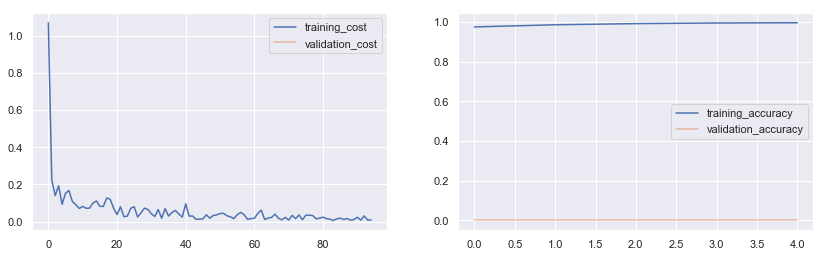

initial_cost:  2.6007  initial_acc:  0.0885
epoch_0  --> cost_train:  0.143358 train_acc:  0.9751  -- cost_val:  0  val_acc:  0  ==> grads:  0.00811
epoch_1  --> cost_train:  0.094016 train_acc:  0.9854  -- cost_val:  0  val_acc:  0  ==> grads:  0.00263
epoch_2  --> cost_train:  0.073551 train_acc:  0.9916  -- cost_val:  0  val_acc:  0  ==> grads:  0.00391
epoch_3  --> cost_train:  0.06027 train_acc:  0.9939  -- cost_val:  0  val_acc:  0  ==> grads:  0.00165
epoch_4  --> cost_train:  0.051618 train_acc:  0.9969  -- cost_val:  0  val_acc:  0  ==> grads:  0.00366


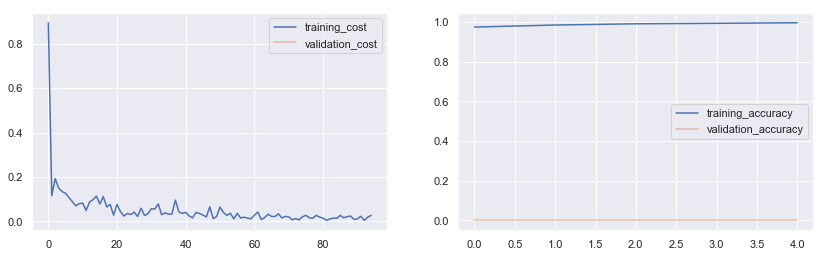

initial_cost:  2.5778  initial_acc:  0.0925
epoch_0  --> cost_train:  0.145068 train_acc:  0.9757  -- cost_val:  0  val_acc:  0  ==> grads:  0.00397
epoch_1  --> cost_train:  0.099729 train_acc:  0.9859  -- cost_val:  0  val_acc:  0  ==> grads:  0.0037
epoch_2  --> cost_train:  0.080607 train_acc:  0.9912  -- cost_val:  0  val_acc:  0  ==> grads:  0.00297
epoch_3  --> cost_train:  0.066178 train_acc:  0.9944  -- cost_val:  0  val_acc:  0  ==> grads:  0.00282
epoch_4  --> cost_train:  0.056202 train_acc:  0.9968  -- cost_val:  0  val_acc:  0  ==> grads:  0.00133


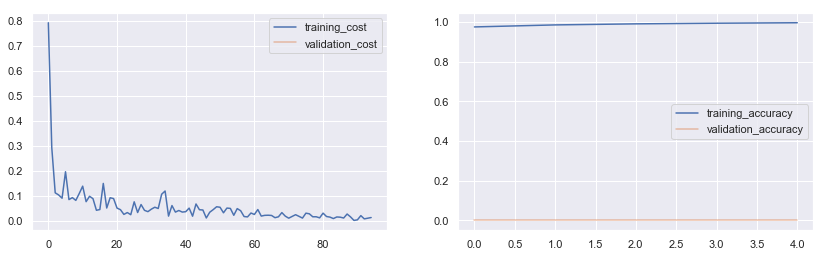

initial_cost:  2.5089  initial_acc:  0.0891
epoch_0  --> cost_train:  0.154184 train_acc:  0.9748  -- cost_val:  0  val_acc:  0  ==> grads:  0.00395
epoch_1  --> cost_train:  0.108534 train_acc:  0.9855  -- cost_val:  0  val_acc:  0  ==> grads:  0.0018
epoch_2  --> cost_train:  0.084926 train_acc:  0.9905  -- cost_val:  0  val_acc:  0  ==> grads:  0.00411
epoch_3  --> cost_train:  0.069866 train_acc:  0.9947  -- cost_val:  0  val_acc:  0  ==> grads:  0.00393
epoch_4  --> cost_train:  0.058637 train_acc:  0.997  -- cost_val:  0  val_acc:  0  ==> grads:  0.00211


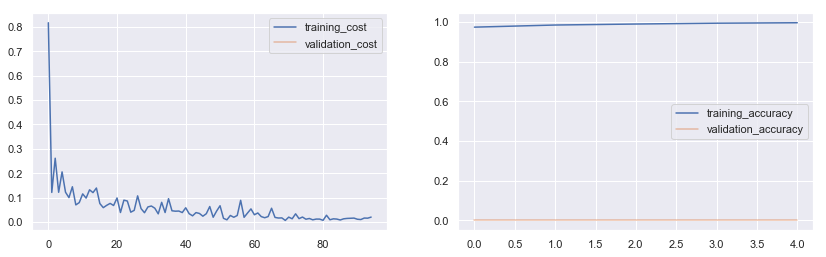

initial_cost:  2.6735  initial_acc:  0.0514
epoch_0  --> cost_train:  0.182805 train_acc:  0.9735  -- cost_val:  0  val_acc:  0  ==> grads:  0.01548
epoch_1  --> cost_train:  0.119079 train_acc:  0.9867  -- cost_val:  0  val_acc:  0  ==> grads:  0.00168
epoch_2  --> cost_train:  0.092639 train_acc:  0.9919  -- cost_val:  0  val_acc:  0  ==> grads:  0.00299
epoch_3  --> cost_train:  0.075972 train_acc:  0.9946  -- cost_val:  0  val_acc:  0  ==> grads:  0.00347
epoch_4  --> cost_train:  0.064996 train_acc:  0.9971  -- cost_val:  0  val_acc:  0  ==> grads:  0.00311


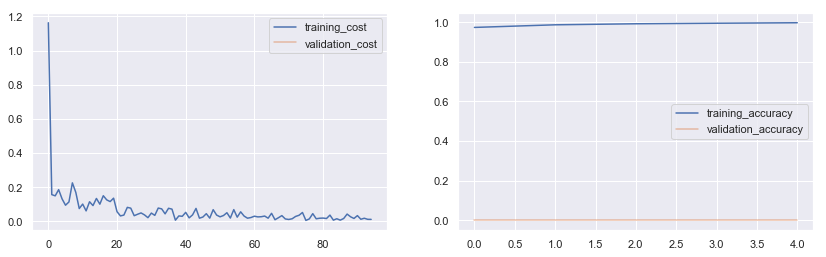

initial_cost:  2.5115  initial_acc:  0.09
epoch_0  --> cost_train:  0.153453 train_acc:  0.9754  -- cost_val:  0  val_acc:  0  ==> grads:  0.00702
epoch_1  --> cost_train:  0.102753 train_acc:  0.9858  -- cost_val:  0  val_acc:  0  ==> grads:  0.00504
epoch_2  --> cost_train:  0.080007 train_acc:  0.9918  -- cost_val:  0  val_acc:  0  ==> grads:  0.00305
epoch_3  --> cost_train:  0.066186 train_acc:  0.9952  -- cost_val:  0  val_acc:  0  ==> grads:  0.00172
epoch_4  --> cost_train:  0.056194 train_acc:  0.9966  -- cost_val:  0  val_acc:  0  ==> grads:  0.00141


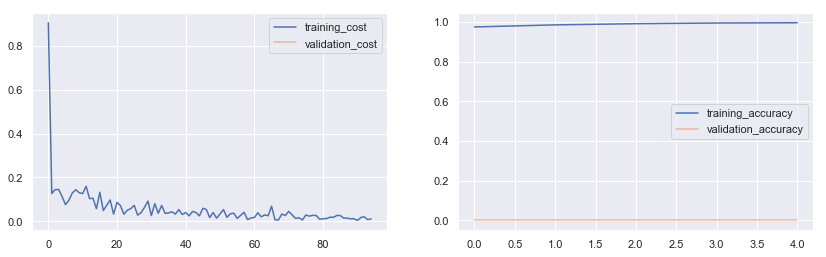

initial_cost:  2.6385  initial_acc:  0.089
epoch_0  --> cost_train:  0.150542 train_acc:  0.9747  -- cost_val:  0  val_acc:  0  ==> grads:  0.00724
epoch_1  --> cost_train:  0.1092 train_acc:  0.9864  -- cost_val:  0  val_acc:  0  ==> grads:  0.00198
epoch_2  --> cost_train:  0.084811 train_acc:  0.9912  -- cost_val:  0  val_acc:  0  ==> grads:  0.00205
epoch_3  --> cost_train:  0.069832 train_acc:  0.9943  -- cost_val:  0  val_acc:  0  ==> grads:  0.00274
epoch_4  --> cost_train:  0.058965 train_acc:  0.9961  -- cost_val:  0  val_acc:  0  ==> grads:  0.00228


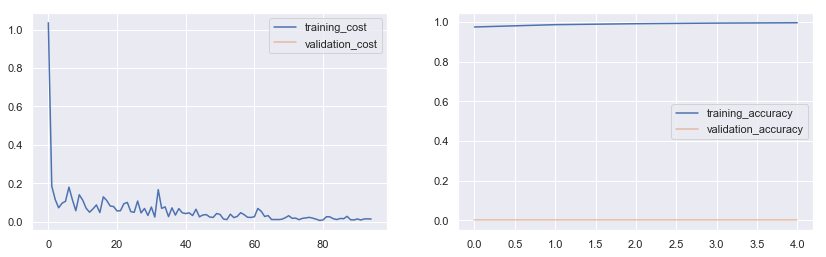

initial_cost:  2.5142  initial_acc:  0.1441
epoch_0  --> cost_train:  0.158326 train_acc:  0.9764  -- cost_val:  0  val_acc:  0  ==> grads:  0.00743
epoch_1  --> cost_train:  0.110334 train_acc:  0.9864  -- cost_val:  0  val_acc:  0  ==> grads:  0.00457
epoch_2  --> cost_train:  0.083912 train_acc:  0.9916  -- cost_val:  0  val_acc:  0  ==> grads:  0.0039
epoch_3  --> cost_train:  0.068974 train_acc:  0.995  -- cost_val:  0  val_acc:  0  ==> grads:  0.00171
epoch_4  --> cost_train:  0.058447 train_acc:  0.9967  -- cost_val:  0  val_acc:  0  ==> grads:  0.00225


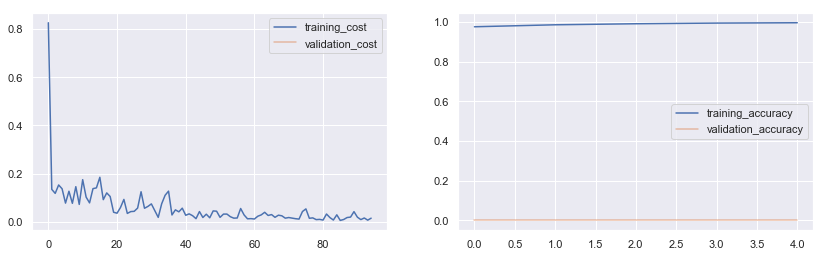

initial_cost:  2.5147  initial_acc:  0.1183
epoch_0  --> cost_train:  0.1398 train_acc:  0.975  -- cost_val:  0  val_acc:  0  ==> grads:  0.00456
epoch_1  --> cost_train:  0.096832 train_acc:  0.9869  -- cost_val:  0  val_acc:  0  ==> grads:  0.00325
epoch_2  --> cost_train:  0.07736 train_acc:  0.9911  -- cost_val:  0  val_acc:  0  ==> grads:  0.00394
epoch_3  --> cost_train:  0.063557 train_acc:  0.9943  -- cost_val:  0  val_acc:  0  ==> grads:  0.00064
epoch_4  --> cost_train:  0.053725 train_acc:  0.9969  -- cost_val:  0  val_acc:  0  ==> grads:  0.0021


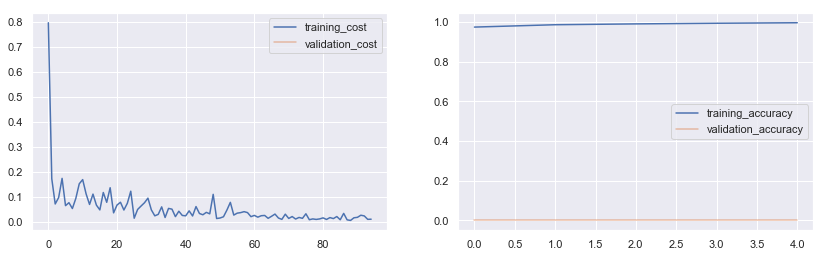

initial_cost:  2.5029  initial_acc:  0.0752
epoch_0  --> cost_train:  0.150405 train_acc:  0.976  -- cost_val:  0  val_acc:  0  ==> grads:  0.00527
epoch_1  --> cost_train:  0.103237 train_acc:  0.9854  -- cost_val:  0  val_acc:  0  ==> grads:  0.00338
epoch_2  --> cost_train:  0.078258 train_acc:  0.9914  -- cost_val:  0  val_acc:  0  ==> grads:  0.00381
epoch_3  --> cost_train:  0.064091 train_acc:  0.9943  -- cost_val:  0  val_acc:  0  ==> grads:  0.00306
epoch_4  --> cost_train:  0.055139 train_acc:  0.9958  -- cost_val:  0  val_acc:  0  ==> grads:  0.00336


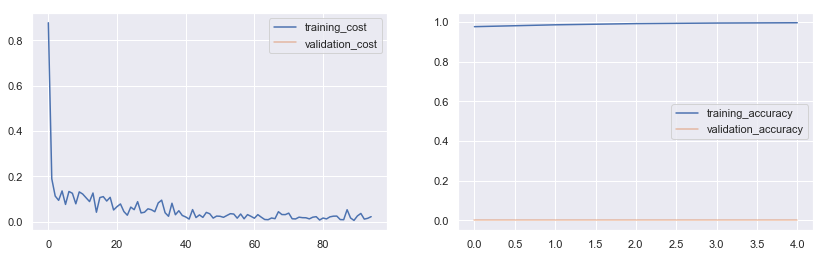

initial_cost:  2.4337  initial_acc:  0.1221
epoch_0  --> cost_train:  0.145637 train_acc:  0.9752  -- cost_val:  0  val_acc:  0  ==> grads:  0.00652
epoch_1  --> cost_train:  0.1022 train_acc:  0.9857  -- cost_val:  0  val_acc:  0  ==> grads:  0.00335
epoch_2  --> cost_train:  0.080479 train_acc:  0.9911  -- cost_val:  0  val_acc:  0  ==> grads:  0.00276
epoch_3  --> cost_train:  0.066313 train_acc:  0.9936  -- cost_val:  0  val_acc:  0  ==> grads:  0.00224
epoch_4  --> cost_train:  0.056854 train_acc:  0.9968  -- cost_val:  0  val_acc:  0  ==> grads:  0.00131


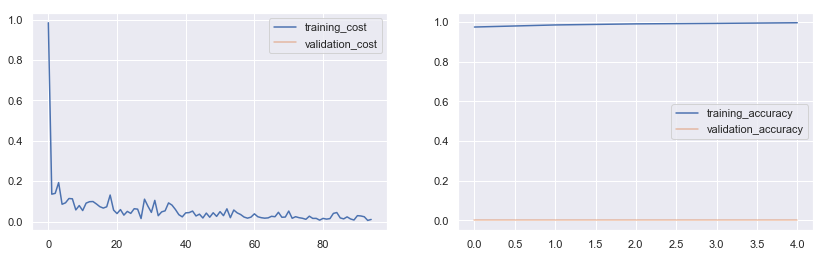

initial_cost:  2.5328  initial_acc:  0.0813
epoch_0  --> cost_train:  0.151358 train_acc:  0.9758  -- cost_val:  0  val_acc:  0  ==> grads:  0.0059
epoch_1  --> cost_train:  0.103326 train_acc:  0.9859  -- cost_val:  0  val_acc:  0  ==> grads:  0.00489
epoch_2  --> cost_train:  0.079018 train_acc:  0.9917  -- cost_val:  0  val_acc:  0  ==> grads:  0.00232
epoch_3  --> cost_train:  0.064897 train_acc:  0.9946  -- cost_val:  0  val_acc:  0  ==> grads:  0.00427
epoch_4  --> cost_train:  0.054879 train_acc:  0.9966  -- cost_val:  0  val_acc:  0  ==> grads:  0.00181


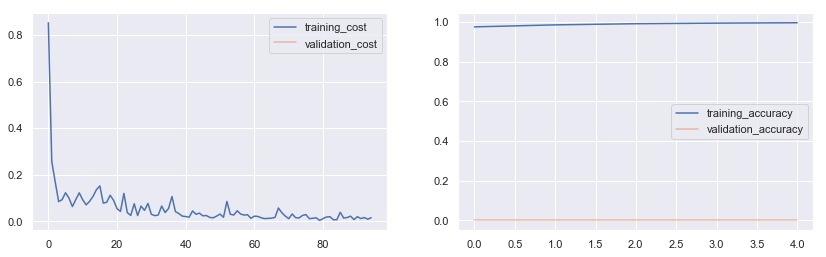

initial_cost:  2.6181  initial_acc:  0.057
epoch_0  --> cost_train:  0.173621 train_acc:  0.9746  -- cost_val:  0  val_acc:  0  ==> grads:  0.00224
epoch_1  --> cost_train:  0.118616 train_acc:  0.9849  -- cost_val:  0  val_acc:  0  ==> grads:  0.00418
epoch_2  --> cost_train:  0.088354 train_acc:  0.9911  -- cost_val:  0  val_acc:  0  ==> grads:  0.00277
epoch_3  --> cost_train:  0.072018 train_acc:  0.9945  -- cost_val:  0  val_acc:  0  ==> grads:  0.00253
epoch_4  --> cost_train:  0.061981 train_acc:  0.996  -- cost_val:  0  val_acc:  0  ==> grads:  0.00219


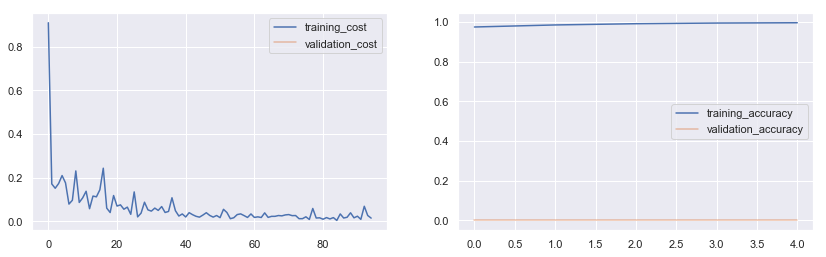

initial_cost:  2.5177  initial_acc:  0.1207
epoch_0  --> cost_train:  0.157353 train_acc:  0.9762  -- cost_val:  0  val_acc:  0  ==> grads:  0.00607
epoch_1  --> cost_train:  0.107284 train_acc:  0.9859  -- cost_val:  0  val_acc:  0  ==> grads:  0.00406
epoch_2  --> cost_train:  0.082986 train_acc:  0.9915  -- cost_val:  0  val_acc:  0  ==> grads:  0.00196
epoch_3  --> cost_train:  0.068226 train_acc:  0.9947  -- cost_val:  0  val_acc:  0  ==> grads:  0.00198
epoch_4  --> cost_train:  0.057545 train_acc:  0.996  -- cost_val:  0  val_acc:  0  ==> grads:  0.0012


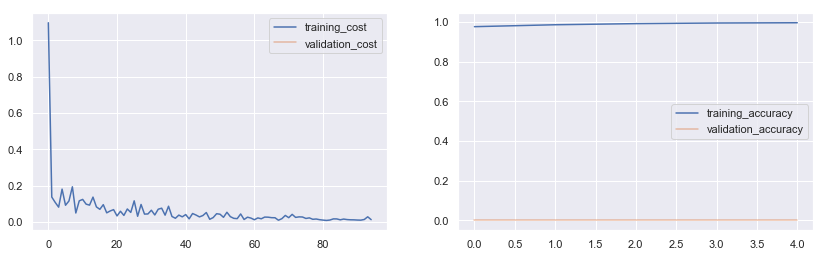

initial_cost:  2.6624  initial_acc:  0.0602
epoch_0  --> cost_train:  0.142784 train_acc:  0.9754  -- cost_val:  0  val_acc:  0  ==> grads:  0.00314
epoch_1  --> cost_train:  0.102845 train_acc:  0.984  -- cost_val:  0  val_acc:  0  ==> grads:  0.00605
epoch_2  --> cost_train:  0.081391 train_acc:  0.9912  -- cost_val:  0  val_acc:  0  ==> grads:  0.00481
epoch_3  --> cost_train:  0.068297 train_acc:  0.9945  -- cost_val:  0  val_acc:  0  ==> grads:  0.00357
epoch_4  --> cost_train:  0.058694 train_acc:  0.9964  -- cost_val:  0  val_acc:  0  ==> grads:  0.0023


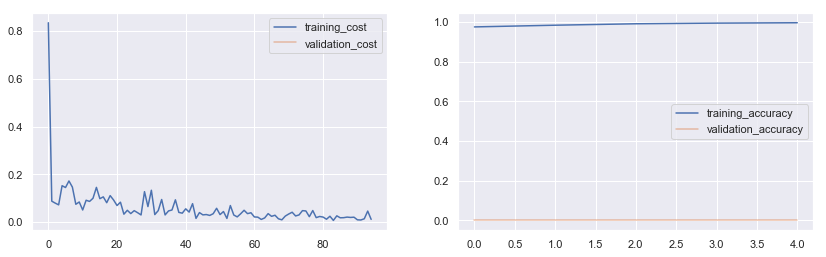

initial_cost:  2.3761  initial_acc:  0.1388
epoch_0  --> cost_train:  0.143089 train_acc:  0.9756  -- cost_val:  0  val_acc:  0  ==> grads:  0.00238
epoch_1  --> cost_train:  0.098979 train_acc:  0.9869  -- cost_val:  0  val_acc:  0  ==> grads:  0.00417
epoch_2  --> cost_train:  0.078861 train_acc:  0.9924  -- cost_val:  0  val_acc:  0  ==> grads:  0.00536
epoch_3  --> cost_train:  0.065726 train_acc:  0.9941  -- cost_val:  0  val_acc:  0  ==> grads:  0.00332
epoch_4  --> cost_train:  0.056085 train_acc:  0.9969  -- cost_val:  0  val_acc:  0  ==> grads:  0.00209


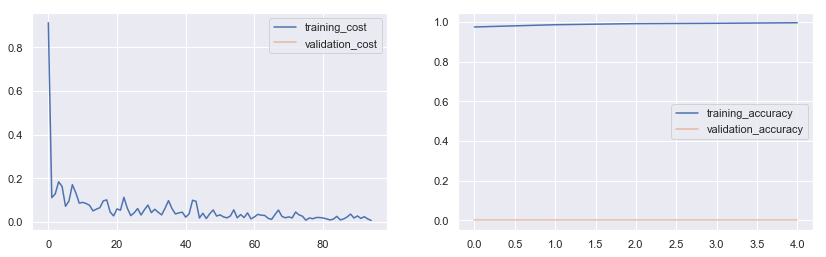

initial_cost:  2.5268  initial_acc:  0.1081
epoch_0  --> cost_train:  0.157416 train_acc:  0.9752  -- cost_val:  0  val_acc:  0  ==> grads:  0.008
epoch_1  --> cost_train:  0.109389 train_acc:  0.9854  -- cost_val:  0  val_acc:  0  ==> grads:  0.00403
epoch_2  --> cost_train:  0.084858 train_acc:  0.9917  -- cost_val:  0  val_acc:  0  ==> grads:  0.00138
epoch_3  --> cost_train:  0.070837 train_acc:  0.995  -- cost_val:  0  val_acc:  0  ==> grads:  0.00236
epoch_4  --> cost_train:  0.060112 train_acc:  0.9963  -- cost_val:  0  val_acc:  0  ==> grads:  0.00349


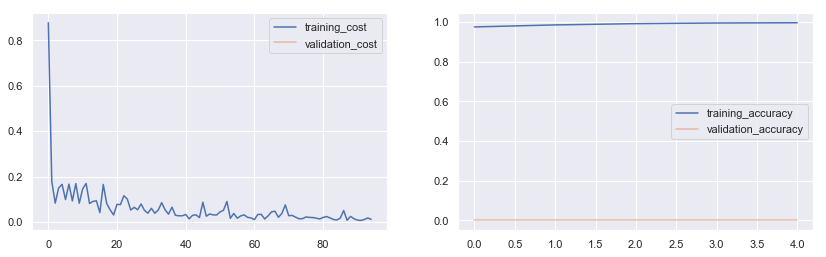

initial_cost:  2.4282  initial_acc:  0.1763
epoch_0  --> cost_train:  0.158805 train_acc:  0.9757  -- cost_val:  0  val_acc:  0  ==> grads:  0.00607
epoch_1  --> cost_train:  0.107447 train_acc:  0.9859  -- cost_val:  0  val_acc:  0  ==> grads:  0.00403
epoch_2  --> cost_train:  0.082944 train_acc:  0.9917  -- cost_val:  0  val_acc:  0  ==> grads:  0.0026
epoch_3  --> cost_train:  0.068225 train_acc:  0.9949  -- cost_val:  0  val_acc:  0  ==> grads:  0.00403
epoch_4  --> cost_train:  0.058418 train_acc:  0.9965  -- cost_val:  0  val_acc:  0  ==> grads:  0.00453


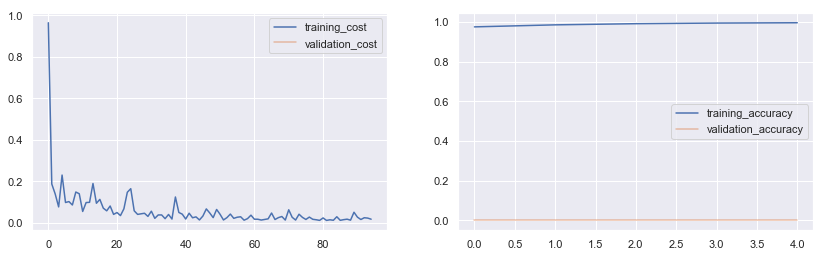

initial_cost:  2.6167  initial_acc:  0.071
epoch_0  --> cost_train:  0.1602 train_acc:  0.9748  -- cost_val:  0  val_acc:  0  ==> grads:  0.00437
epoch_1  --> cost_train:  0.111674 train_acc:  0.9855  -- cost_val:  0  val_acc:  0  ==> grads:  0.0042
epoch_2  --> cost_train:  0.087489 train_acc:  0.9919  -- cost_val:  0  val_acc:  0  ==> grads:  0.00254
epoch_3  --> cost_train:  0.072167 train_acc:  0.9941  -- cost_val:  0  val_acc:  0  ==> grads:  0.00236
epoch_4  --> cost_train:  0.061277 train_acc:  0.9951  -- cost_val:  0  val_acc:  0  ==> grads:  0.00206


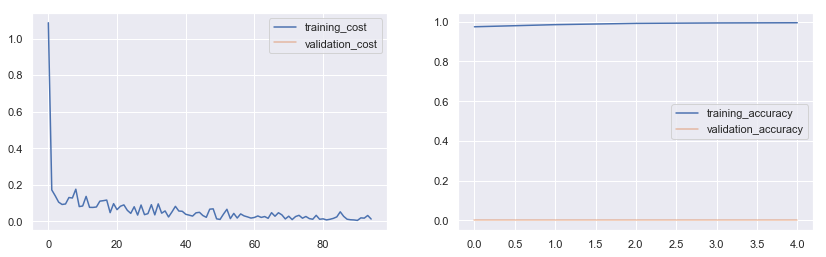

initial_cost:  2.6838  initial_acc:  0.0858
epoch_0  --> cost_train:  0.1585 train_acc:  0.9747  -- cost_val:  0  val_acc:  0  ==> grads:  0.01294
epoch_1  --> cost_train:  0.105521 train_acc:  0.9856  -- cost_val:  0  val_acc:  0  ==> grads:  0.00378
epoch_2  --> cost_train:  0.084037 train_acc:  0.992  -- cost_val:  0  val_acc:  0  ==> grads:  0.00535
epoch_3  --> cost_train:  0.068633 train_acc:  0.995  -- cost_val:  0  val_acc:  0  ==> grads:  0.00444
epoch_4  --> cost_train:  0.057877 train_acc:  0.9965  -- cost_val:  0  val_acc:  0  ==> grads:  0.00365


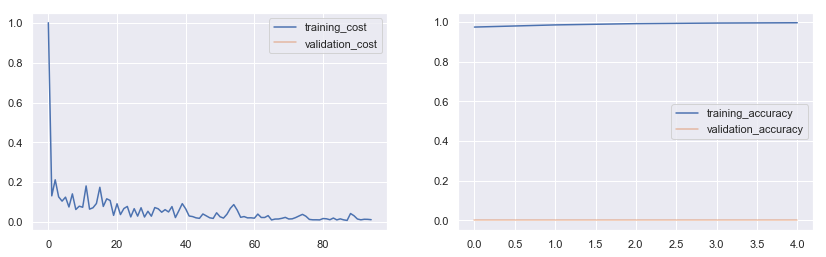

In [6]:
trials = 20
losses = []
for t in range(trials):
    nn_madam = NN_madam(size_h_layer=(X__.shape[1], 256,256, len(np.unique(y__))), 
                              activation_h='ReLU', activation_o='softmax', initialization='truncnorm',
                              l_rate= 0.0001, l_decay=0.95, bias= 1 , l2_reg= 0.0, dropout=(0, (0,0.5,0.5)),
                              optimizer=('madam',{'beta1':0.9, 'beta2':0.999}),
                              print_=1, plots=1)
    nn_madam.train_nn(X__, y__, epochs= 5, batch_size=128, nr_shuffles=1, cval=None, grads_stopping=True)
    losses.append(nn_madam.tr_batch_cost)

In [7]:
madam_mnist = losses.copy()

In [8]:
madam_costs = np.zeros((len(madam_mnist[0]), len(madam_mnist)))
for i in range(len(madam_mnist)):
    madam_costs[:,i] = madam_mnist[i]

### Adam testing on MNIST

initial_cost:  2.5976  initial_acc:  0.0812
epoch_0  --> cost_train:  0.332326 train_acc:  0.9629  -- cost_val:  0  val_acc:  0  ==> grads:  0.00505
epoch_1  --> cost_train:  0.224032 train_acc:  0.9748  -- cost_val:  0  val_acc:  0  ==> grads:  0.00344
epoch_2  --> cost_train:  0.179056 train_acc:  0.9818  -- cost_val:  0  val_acc:  0  ==> grads:  0.00557
epoch_3  --> cost_train:  0.152551 train_acc:  0.9852  -- cost_val:  0  val_acc:  0  ==> grads:  0.0032
epoch_4  --> cost_train:  0.131203 train_acc:  0.989  -- cost_val:  0  val_acc:  0  ==> grads:  0.00594


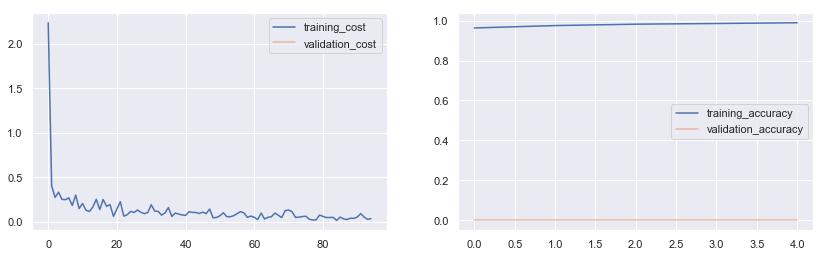

initial_cost:  2.6904  initial_acc:  0.1041
epoch_0  --> cost_train:  0.367426 train_acc:  0.9637  -- cost_val:  0  val_acc:  0  ==> grads:  0.00476
epoch_1  --> cost_train:  0.237547 train_acc:  0.9754  -- cost_val:  0  val_acc:  0  ==> grads:  0.00326
epoch_2  --> cost_train:  0.185421 train_acc:  0.9819  -- cost_val:  0  val_acc:  0  ==> grads:  0.00492
epoch_3  --> cost_train:  0.154922 train_acc:  0.9857  -- cost_val:  0  val_acc:  0  ==> grads:  0.00292
epoch_4  --> cost_train:  0.134297 train_acc:  0.989  -- cost_val:  0  val_acc:  0  ==> grads:  0.00187


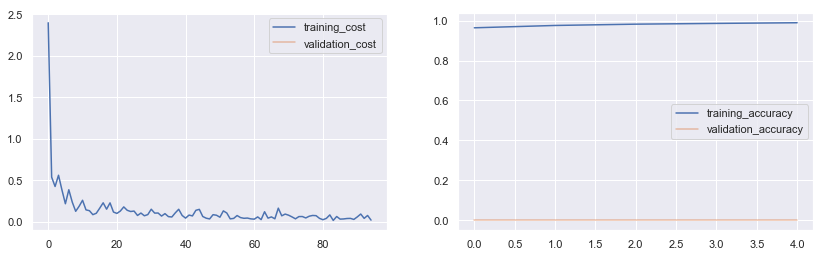

initial_cost:  2.5848  initial_acc:  0.1001
epoch_0  --> cost_train:  0.345026 train_acc:  0.963  -- cost_val:  0  val_acc:  0  ==> grads:  0.00509
epoch_1  --> cost_train:  0.226816 train_acc:  0.9745  -- cost_val:  0  val_acc:  0  ==> grads:  0.00366
epoch_2  --> cost_train:  0.177888 train_acc:  0.9813  -- cost_val:  0  val_acc:  0  ==> grads:  0.00389
epoch_3  --> cost_train:  0.148945 train_acc:  0.9856  -- cost_val:  0  val_acc:  0  ==> grads:  0.00218
epoch_4  --> cost_train:  0.130218 train_acc:  0.9885  -- cost_val:  0  val_acc:  0  ==> grads:  0.0042


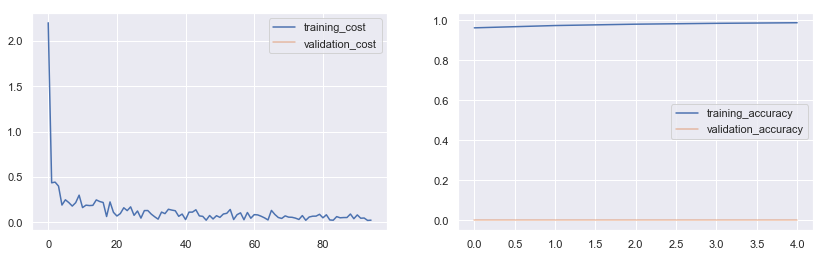

initial_cost:  2.5834  initial_acc:  0.0636
epoch_0  --> cost_train:  0.297305 train_acc:  0.9636  -- cost_val:  0  val_acc:  0  ==> grads:  0.00351
epoch_1  --> cost_train:  0.208684 train_acc:  0.9755  -- cost_val:  0  val_acc:  0  ==> grads:  0.00666
epoch_2  --> cost_train:  0.163596 train_acc:  0.9825  -- cost_val:  0  val_acc:  0  ==> grads:  0.0027
epoch_3  --> cost_train:  0.140962 train_acc:  0.9858  -- cost_val:  0  val_acc:  0  ==> grads:  0.00424
epoch_4  --> cost_train:  0.123835 train_acc:  0.9887  -- cost_val:  0  val_acc:  0  ==> grads:  0.00512


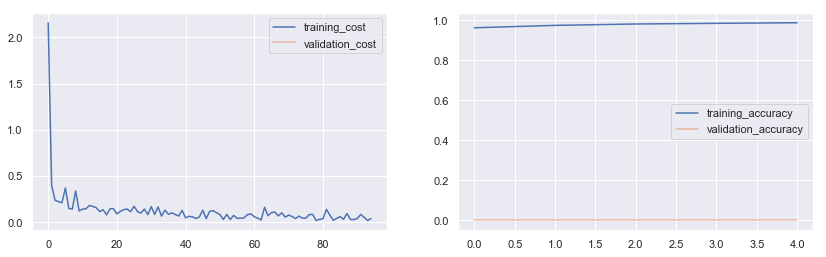

initial_cost:  2.6467  initial_acc:  0.0945
epoch_0  --> cost_train:  0.324153 train_acc:  0.9629  -- cost_val:  0  val_acc:  0  ==> grads:  0.00505
epoch_1  --> cost_train:  0.214697 train_acc:  0.9752  -- cost_val:  0  val_acc:  0  ==> grads:  0.00489
epoch_2  --> cost_train:  0.172446 train_acc:  0.9814  -- cost_val:  0  val_acc:  0  ==> grads:  0.00413
epoch_3  --> cost_train:  0.14775 train_acc:  0.9854  -- cost_val:  0  val_acc:  0  ==> grads:  0.00272
epoch_4  --> cost_train:  0.128943 train_acc:  0.9886  -- cost_val:  0  val_acc:  0  ==> grads:  0.00701


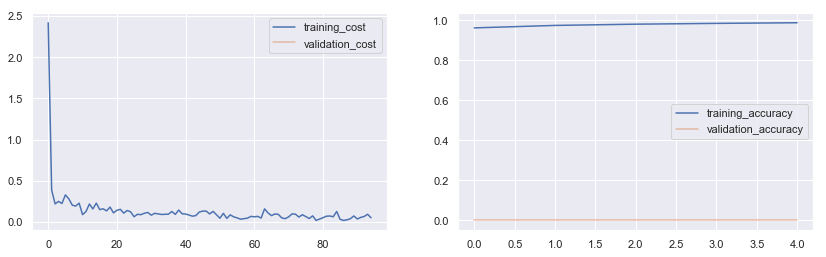

initial_cost:  2.5958  initial_acc:  0.0758
epoch_0  --> cost_train:  0.312058 train_acc:  0.9641  -- cost_val:  0  val_acc:  0  ==> grads:  0.01007
epoch_1  --> cost_train:  0.210589 train_acc:  0.9753  -- cost_val:  0  val_acc:  0  ==> grads:  0.00379
epoch_2  --> cost_train:  0.164584 train_acc:  0.9812  -- cost_val:  0  val_acc:  0  ==> grads:  0.00352
epoch_3  --> cost_train:  0.137812 train_acc:  0.9856  -- cost_val:  0  val_acc:  0  ==> grads:  0.00312
epoch_4  --> cost_train:  0.119187 train_acc:  0.9889  -- cost_val:  0  val_acc:  0  ==> grads:  0.00405


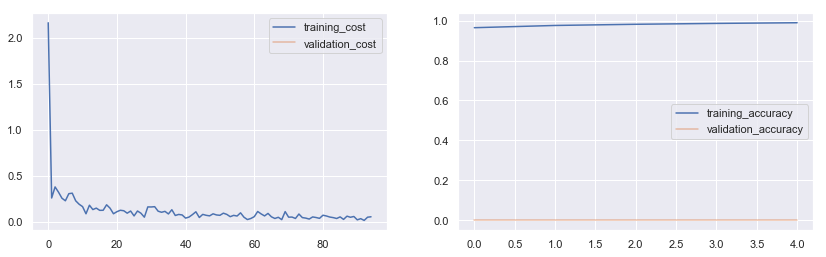

initial_cost:  2.5204  initial_acc:  0.0802
epoch_0  --> cost_train:  0.298079 train_acc:  0.9638  -- cost_val:  0  val_acc:  0  ==> grads:  0.00493
epoch_1  --> cost_train:  0.20905 train_acc:  0.9746  -- cost_val:  0  val_acc:  0  ==> grads:  0.00207
epoch_2  --> cost_train:  0.16733 train_acc:  0.981  -- cost_val:  0  val_acc:  0  ==> grads:  0.00369
epoch_3  --> cost_train:  0.138764 train_acc:  0.9852  -- cost_val:  0  val_acc:  0  ==> grads:  0.00368
epoch_4  --> cost_train:  0.122171 train_acc:  0.9881  -- cost_val:  0  val_acc:  0  ==> grads:  0.00248


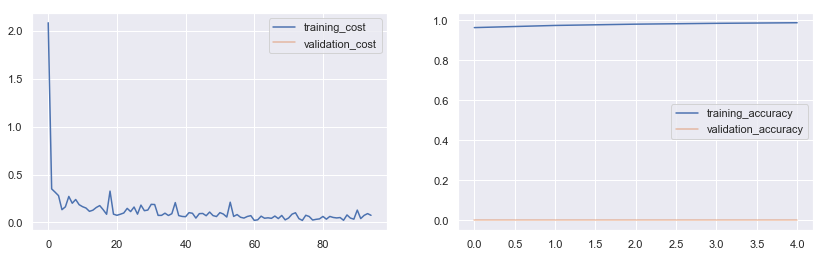

initial_cost:  2.574  initial_acc:  0.0946
epoch_0  --> cost_train:  0.339858 train_acc:  0.9648  -- cost_val:  0  val_acc:  0  ==> grads:  0.00541
epoch_1  --> cost_train:  0.221374 train_acc:  0.9758  -- cost_val:  0  val_acc:  0  ==> grads:  0.00798
epoch_2  --> cost_train:  0.176846 train_acc:  0.9822  -- cost_val:  0  val_acc:  0  ==> grads:  0.00438
epoch_3  --> cost_train:  0.150557 train_acc:  0.9859  -- cost_val:  0  val_acc:  0  ==> grads:  0.00501
epoch_4  --> cost_train:  0.13128 train_acc:  0.9892  -- cost_val:  0  val_acc:  0  ==> grads:  0.00207


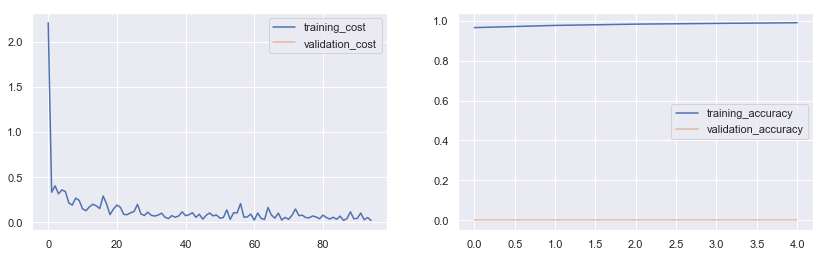

initial_cost:  2.4997  initial_acc:  0.1038
epoch_0  --> cost_train:  0.306947 train_acc:  0.9628  -- cost_val:  0  val_acc:  0  ==> grads:  0.00843
epoch_1  --> cost_train:  0.208774 train_acc:  0.9754  -- cost_val:  0  val_acc:  0  ==> grads:  0.00418
epoch_2  --> cost_train:  0.163333 train_acc:  0.9808  -- cost_val:  0  val_acc:  0  ==> grads:  0.00627
epoch_3  --> cost_train:  0.141462 train_acc:  0.9852  -- cost_val:  0  val_acc:  0  ==> grads:  0.00416
epoch_4  --> cost_train:  0.124225 train_acc:  0.9882  -- cost_val:  0  val_acc:  0  ==> grads:  0.00621


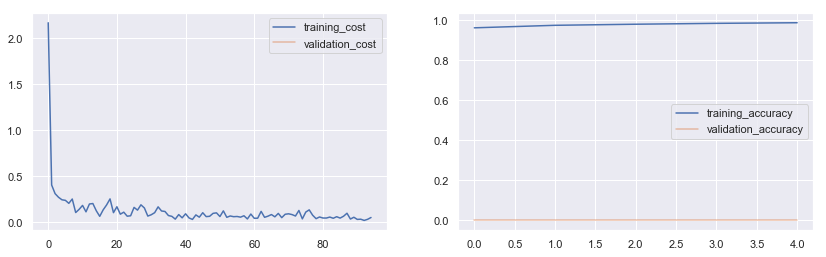

initial_cost:  2.6131  initial_acc:  0.1424
epoch_0  --> cost_train:  0.304868 train_acc:  0.963  -- cost_val:  0  val_acc:  0  ==> grads:  0.00512
epoch_1  --> cost_train:  0.207518 train_acc:  0.9744  -- cost_val:  0  val_acc:  0  ==> grads:  0.00626
epoch_2  --> cost_train:  0.165332 train_acc:  0.9817  -- cost_val:  0  val_acc:  0  ==> grads:  0.00328
epoch_3  --> cost_train:  0.1408 train_acc:  0.9861  -- cost_val:  0  val_acc:  0  ==> grads:  0.00325
epoch_4  --> cost_train:  0.123084 train_acc:  0.9884  -- cost_val:  0  val_acc:  0  ==> grads:  0.00394


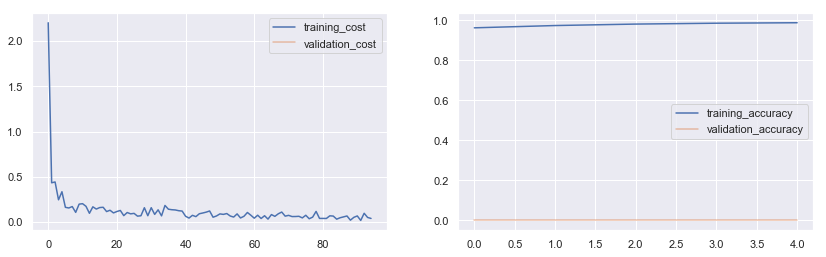

initial_cost:  2.6166  initial_acc:  0.0972
epoch_0  --> cost_train:  0.317421 train_acc:  0.9634  -- cost_val:  0  val_acc:  0  ==> grads:  0.00622
epoch_1  --> cost_train:  0.226329 train_acc:  0.9747  -- cost_val:  0  val_acc:  0  ==> grads:  0.00449
epoch_2  --> cost_train:  0.178765 train_acc:  0.9815  -- cost_val:  0  val_acc:  0  ==> grads:  0.00654
epoch_3  --> cost_train:  0.151889 train_acc:  0.9857  -- cost_val:  0  val_acc:  0  ==> grads:  0.00436
epoch_4  --> cost_train:  0.131584 train_acc:  0.9879  -- cost_val:  0  val_acc:  0  ==> grads:  0.00353


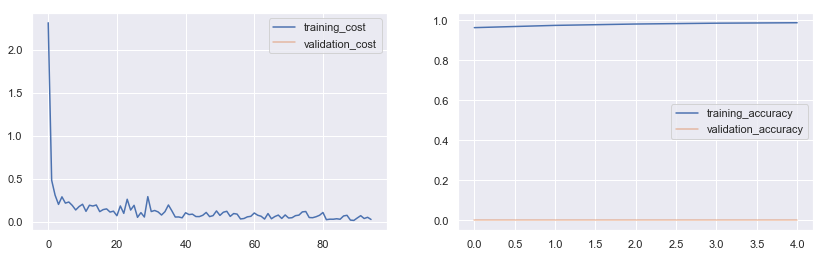

initial_cost:  2.4961  initial_acc:  0.0898
epoch_0  --> cost_train:  0.3251 train_acc:  0.9632  -- cost_val:  0  val_acc:  0  ==> grads:  0.00526
epoch_1  --> cost_train:  0.218292 train_acc:  0.9752  -- cost_val:  0  val_acc:  0  ==> grads:  0.0034
epoch_2  --> cost_train:  0.173358 train_acc:  0.9813  -- cost_val:  0  val_acc:  0  ==> grads:  0.00555
epoch_3  --> cost_train:  0.146614 train_acc:  0.9859  -- cost_val:  0  val_acc:  0  ==> grads:  0.00377
epoch_4  --> cost_train:  0.126862 train_acc:  0.9889  -- cost_val:  0  val_acc:  0  ==> grads:  0.0043


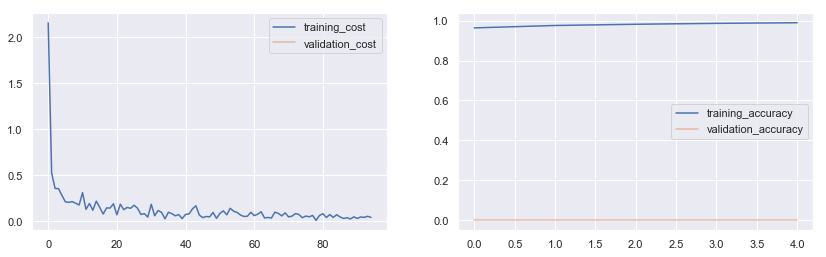

initial_cost:  2.5089  initial_acc:  0.0956
epoch_0  --> cost_train:  0.325547 train_acc:  0.9627  -- cost_val:  0  val_acc:  0  ==> grads:  0.00653
epoch_1  --> cost_train:  0.216718 train_acc:  0.9752  -- cost_val:  0  val_acc:  0  ==> grads:  0.00738
epoch_2  --> cost_train:  0.172398 train_acc:  0.9821  -- cost_val:  0  val_acc:  0  ==> grads:  0.00323
epoch_3  --> cost_train:  0.145413 train_acc:  0.9856  -- cost_val:  0  val_acc:  0  ==> grads:  0.00293
epoch_4  --> cost_train:  0.129165 train_acc:  0.9888  -- cost_val:  0  val_acc:  0  ==> grads:  0.00316


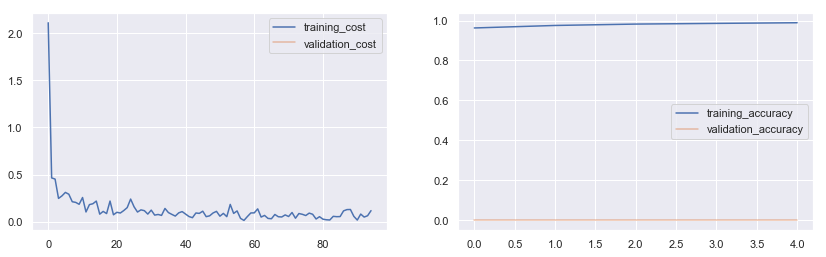

initial_cost:  2.5596  initial_acc:  0.0963
epoch_0  --> cost_train:  0.2963 train_acc:  0.9641  -- cost_val:  0  val_acc:  0  ==> grads:  0.00439
epoch_1  --> cost_train:  0.209934 train_acc:  0.9755  -- cost_val:  0  val_acc:  0  ==> grads:  0.00384
epoch_2  --> cost_train:  0.166984 train_acc:  0.9814  -- cost_val:  0  val_acc:  0  ==> grads:  0.00367
epoch_3  --> cost_train:  0.140287 train_acc:  0.9857  -- cost_val:  0  val_acc:  0  ==> grads:  0.00323
epoch_4  --> cost_train:  0.122885 train_acc:  0.989  -- cost_val:  0  val_acc:  0  ==> grads:  0.00341


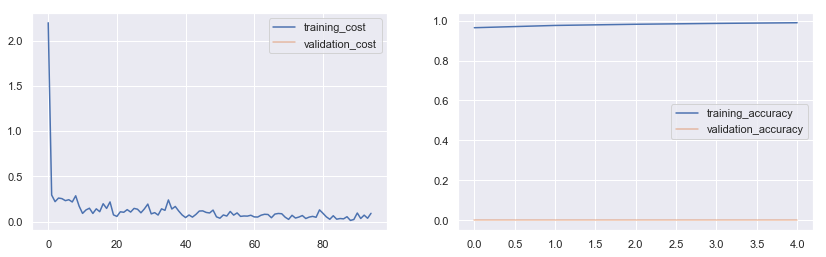

initial_cost:  2.4901  initial_acc:  0.0814
epoch_0  --> cost_train:  0.313874 train_acc:  0.9635  -- cost_val:  0  val_acc:  0  ==> grads:  0.00654
epoch_1  --> cost_train:  0.212503 train_acc:  0.9758  -- cost_val:  0  val_acc:  0  ==> grads:  0.00483
epoch_2  --> cost_train:  0.163595 train_acc:  0.9826  -- cost_val:  0  val_acc:  0  ==> grads:  0.00326
epoch_3  --> cost_train:  0.139792 train_acc:  0.987  -- cost_val:  0  val_acc:  0  ==> grads:  0.0081
epoch_4  --> cost_train:  0.122081 train_acc:  0.9894  -- cost_val:  0  val_acc:  0  ==> grads:  0.00311


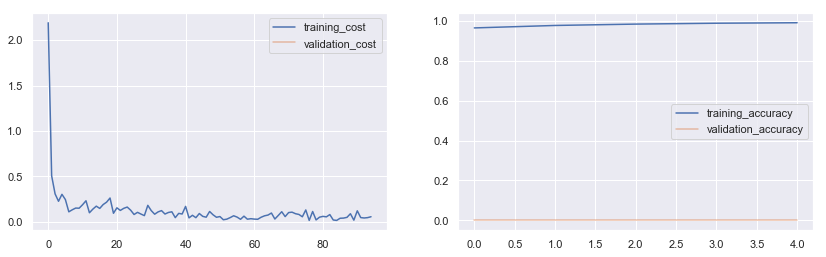

initial_cost:  2.5874  initial_acc:  0.1167
epoch_0  --> cost_train:  0.337063 train_acc:  0.962  -- cost_val:  0  val_acc:  0  ==> grads:  0.00442
epoch_1  --> cost_train:  0.227629 train_acc:  0.9755  -- cost_val:  0  val_acc:  0  ==> grads:  0.00346
epoch_2  --> cost_train:  0.178663 train_acc:  0.9816  -- cost_val:  0  val_acc:  0  ==> grads:  0.00376
epoch_3  --> cost_train:  0.149246 train_acc:  0.9858  -- cost_val:  0  val_acc:  0  ==> grads:  0.00383
epoch_4  --> cost_train:  0.128423 train_acc:  0.9891  -- cost_val:  0  val_acc:  0  ==> grads:  0.00339


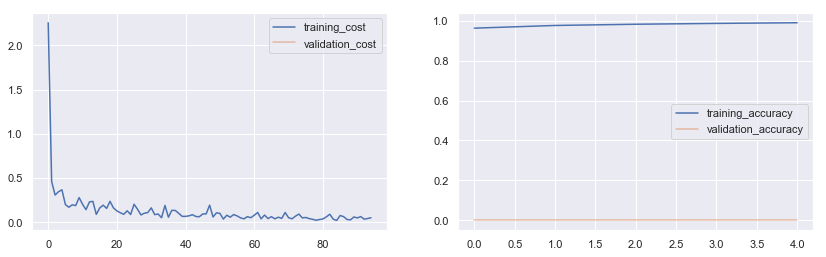

initial_cost:  2.6192  initial_acc:  0.1104
epoch_0  --> cost_train:  0.321274 train_acc:  0.9638  -- cost_val:  0  val_acc:  0  ==> grads:  0.00475
epoch_1  --> cost_train:  0.222368 train_acc:  0.9748  -- cost_val:  0  val_acc:  0  ==> grads:  0.00293
epoch_2  --> cost_train:  0.175467 train_acc:  0.9818  -- cost_val:  0  val_acc:  0  ==> grads:  0.00292
epoch_3  --> cost_train:  0.149401 train_acc:  0.9864  -- cost_val:  0  val_acc:  0  ==> grads:  0.00503
epoch_4  --> cost_train:  0.129466 train_acc:  0.9882  -- cost_val:  0  val_acc:  0  ==> grads:  0.00482


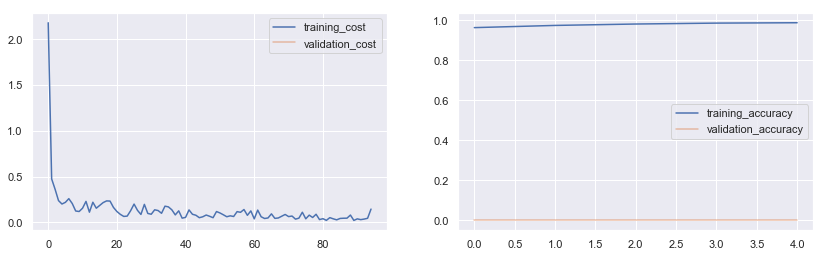

initial_cost:  2.6586  initial_acc:  0.0788
epoch_0  --> cost_train:  0.336721 train_acc:  0.9639  -- cost_val:  0  val_acc:  0  ==> grads:  0.00453
epoch_1  --> cost_train:  0.232318 train_acc:  0.976  -- cost_val:  0  val_acc:  0  ==> grads:  0.00519
epoch_2  --> cost_train:  0.181374 train_acc:  0.9812  -- cost_val:  0  val_acc:  0  ==> grads:  0.00369
epoch_3  --> cost_train:  0.153024 train_acc:  0.9858  -- cost_val:  0  val_acc:  0  ==> grads:  0.00323
epoch_4  --> cost_train:  0.133668 train_acc:  0.9884  -- cost_val:  0  val_acc:  0  ==> grads:  0.00257


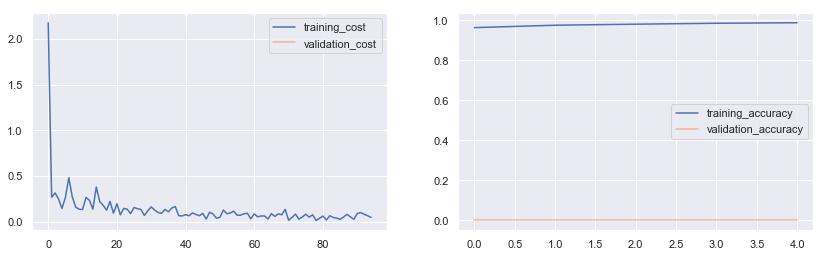

initial_cost:  2.5509  initial_acc:  0.1204
epoch_0  --> cost_train:  0.323579 train_acc:  0.9633  -- cost_val:  0  val_acc:  0  ==> grads:  0.01082
epoch_1  --> cost_train:  0.213374 train_acc:  0.9754  -- cost_val:  0  val_acc:  0  ==> grads:  0.00775
epoch_2  --> cost_train:  0.174737 train_acc:  0.9812  -- cost_val:  0  val_acc:  0  ==> grads:  0.01002
epoch_3  --> cost_train:  0.148261 train_acc:  0.986  -- cost_val:  0  val_acc:  0  ==> grads:  0.0053
epoch_4  --> cost_train:  0.128135 train_acc:  0.9887  -- cost_val:  0  val_acc:  0  ==> grads:  0.00282


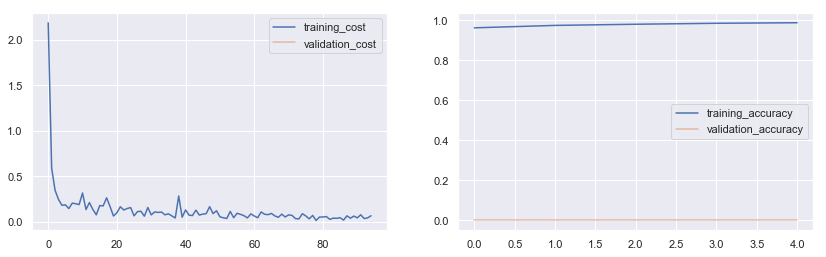

initial_cost:  2.6229  initial_acc:  0.0875
epoch_0  --> cost_train:  0.304395 train_acc:  0.9634  -- cost_val:  0  val_acc:  0  ==> grads:  0.00532
epoch_1  --> cost_train:  0.219218 train_acc:  0.9752  -- cost_val:  0  val_acc:  0  ==> grads:  0.00457
epoch_2  --> cost_train:  0.170412 train_acc:  0.9811  -- cost_val:  0  val_acc:  0  ==> grads:  0.00318
epoch_3  --> cost_train:  0.142342 train_acc:  0.9854  -- cost_val:  0  val_acc:  0  ==> grads:  0.00499
epoch_4  --> cost_train:  0.125624 train_acc:  0.989  -- cost_val:  0  val_acc:  0  ==> grads:  0.00321


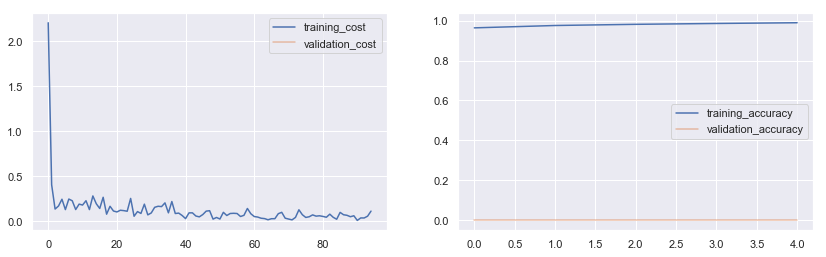

In [9]:
trials = 20
losses = []
for t in range(trials):
    nn_adam = NN_madam(size_h_layer=(X__.shape[1], 256,256, len(np.unique(y__))), 
                              activation_h='ReLU', activation_o='softmax', initialization='truncnorm',
                              l_rate= 0.0001, l_decay=0.95, bias= 1 , l2_reg= 0.0, dropout=(0, (0,0.5,0.5)),
                              optimizer=('adam',{'beta1':0.9, 'beta2':0.999}),
                              print_=1, plots=1)
    nn_adam.train_nn(X__, y__, epochs= 5, batch_size=128, nr_shuffles=1, cval=None, grads_stopping=True)
    losses.append(nn_adam.tr_batch_cost)

In [10]:
adam_mnist = losses.copy()

In [11]:
adam_costs = np.zeros((len(adam_mnist[0]), len(adam_mnist)))
for i in range(len(adam_mnist)):
    adam_costs[:,i] = adam_mnist[i]

### Results on MNIST

In [21]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

Text(0.5, 1.0, 'MNIST Dataset - Avg losses over 20 x 5 epochs trials (batch=128)')

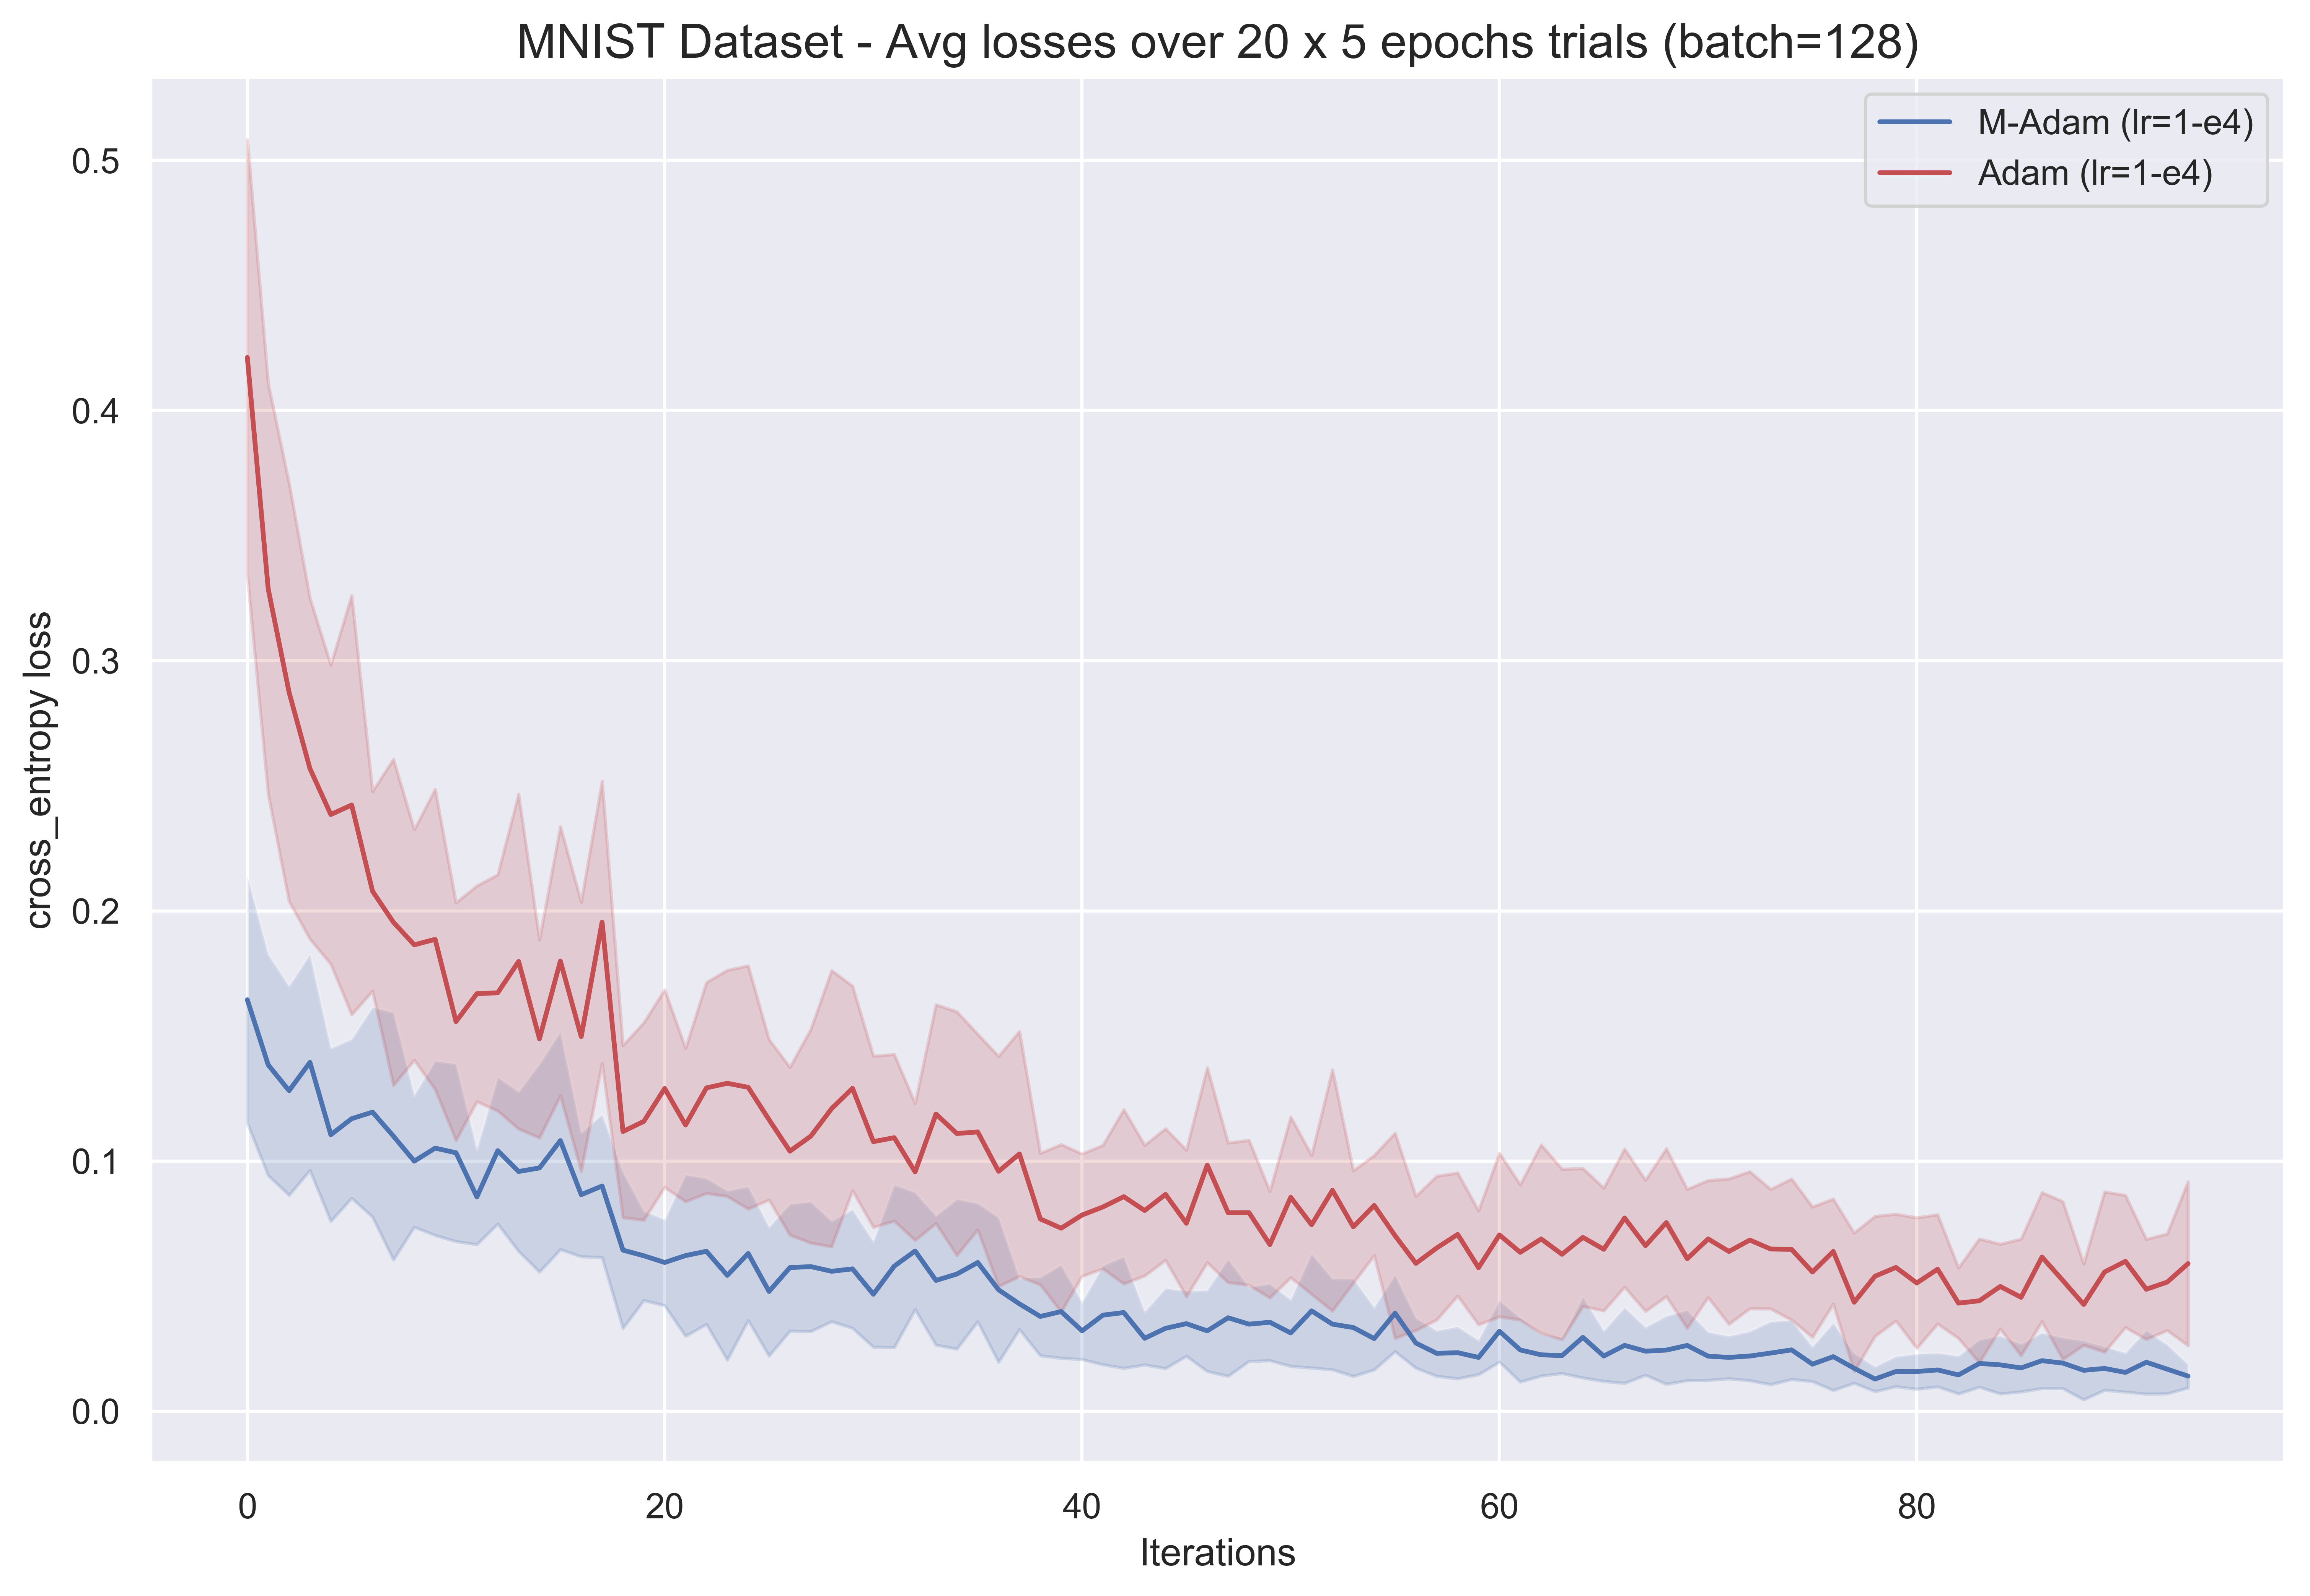

In [22]:
plt.figure(figsize=(12,8))
start = 1
plt.plot(madam_costs.mean(axis=1)[start:], 'b')
plt.fill_between(np.arange(len(madam_costs.mean(axis=1)[start:])), madam_costs.mean(axis=1)[start:], madam_costs.mean(axis=1)[start:] + madam_costs.std(axis=1)[start:], alpha=0.2)
plt.fill_between(np.arange(len(madam_costs.mean(axis=1)[start:])), madam_costs.mean(axis=1)[start:], madam_costs.mean(axis=1)[start:] - madam_costs.std(axis=1)[start:], alpha=0.2,color='b')


plt.plot(adam_costs.mean(axis=1)[1:], 'r')
plt.fill_between(np.arange(len(adam_costs.mean(axis=1)[start:])), adam_costs.mean(axis=1)[start:], adam_costs.mean(axis=1)[start:] + adam_costs.std(axis=1)[start:], alpha=0.2,color='r')
plt.fill_between(np.arange(len(adam_costs.mean(axis=1)[start:])), adam_costs.mean(axis=1)[start:], adam_costs.mean(axis=1)[start:] - adam_costs.std(axis=1)[start:], alpha=0.2,color='r')
plt.legend(['M-Adam (lr=1-e4)', 'Adam (lr=1-e4)'])
plt.xlabel('Iterations', size=12)
plt.ylabel('cross_entropy loss', size=12)
plt.title('MNIST Dataset - Avg losses over 20 x 5 epochs trials (batch=128)', size=15)


## CIFAR-10

In [131]:
from keras.datasets import cifar10

#here we use the (smaller) CIFAR10 test dataset to compare the convergenge of the 2 optimizers
(x, y), (x_train, y__) = cifar10.load_data()

In [132]:
from sklearn.preprocessing import StandardScaler
y__.shape

(10000, 1)

In [133]:
sc_ = StandardScaler()
X__ = sc_.fit_transform(x_train.reshape(-1,3072).astype(float))
#X__test = sc_.transform(x_test.reshape(-1,3072).astype(float))

### M-Adam on CIFAR10

#### Network Structure:

- 2 layers of 512 neurons each
- activation: ReLU
- initialization: truncnorm
- learning rate: 5e-5
- l_rate decay: 0.95
- optimizer: M-Adam {beta1=0.9, beta2=0.999)}
- epochs: 10
- batch_size: 32



In [1]:
trials = 20
losses = []
for t in range(trials):
    nn_madam = NN_madam(size_h_layer=(X__.shape[1], 512,512, len(np.unique(y__))), 
                              activation_h='ReLU', activation_o='softmax', initialization='truncnorm',
                              l_rate= 0.00005, l_decay=0.95, bias= 1 , l2_reg= 0.0, dropout=(0, (0,0.5,0.5)),
                              optimizer=('madam',{'beta1':0.9, 'beta2':0.999}),
                              plot_cost=False, print_=1, plots=1)
    nn_madam.train_nn(X__, y__, epochs= 10, batch_size=32, nr_shuffles=1, cval=None, grads_stopping=True)
    losses.append(nn_madam.tr_batch_cost)

NameError: name 'NN_madam' is not defined

In [166]:
madam_cifar10 = losses.copy()

In [ ]:
madam = np.zeros((len(madam_cifar10[0]), len(madam_cifar10)))
for i in range(len(madam_cifar10)):
    madam[:,i] = madam_cifar10[i]

### Adam on CIFAR10

In [2]:
trials = 20
losses = []
for t in range(trials):
    nn_adam = NN_madam(size_h_layer=(X__.shape[1], 512,512, len(np.unique(y__))), 
                              activation_h='ReLU', activation_o='softmax', initialization='truncnorm',
                              l_rate= 0.00005, l_decay=0.95, bias= 1 , l2_reg= 0.0, dropout=(0, (0,0.5,0.5)),
                              optimizer=('adam',{'beta1':0.9, 'beta2':0.999}),
                              plot_cost=False, print_=1, plots=1)
    nn_adam.train_nn(X__, y__, epochs= 10, batch_size=32, nr_shuffles=1, cval=None, grads_stopping=True)
    losses.append(nn_madam.tr_batch_cost)

NameError: name 'NN_madam' is not defined

In [ ]:
adam_cifar10 = losses.copy()

In [168]:
adam = np.zeros((len(adam_cifar10[0]), len(adam_cifar10)))
for i in range(len(adam_cifar10)):
    adam[:,i] = adam_cifar10[i]

### Results on CIFAR10

Text(0.5, 1.0, 'CIFAR10 Dataset - Avg losses over 20 x 10 epochs trials (batch_size=32)')

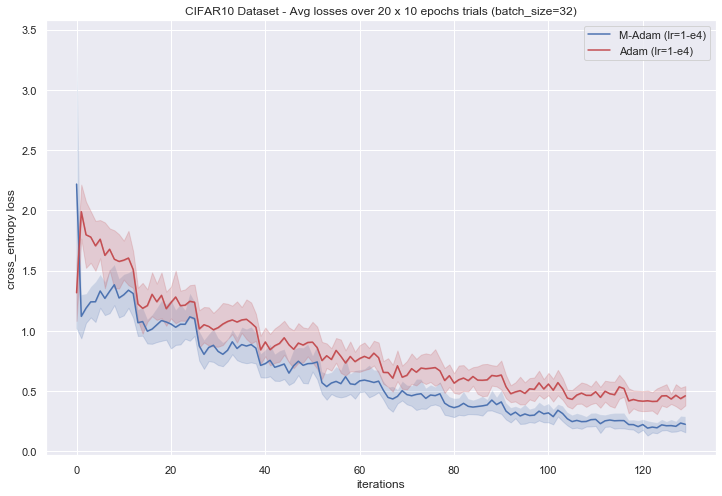

In [226]:

start = 0
plt.figure(figsize=(12,8))
plt.plot(madam.mean(axis=1)[start:], 'b')
plt.fill_between(np.arange(len(madam.mean(axis=1)[start:])), madam.mean(axis=1)[start:], madam.mean(axis=1)[start:] + madam.std(axis=1)[start:], alpha=0.2)
plt.fill_between(np.arange(len(madam.mean(axis=1)[start:])), madam.mean(axis=1)[start:], madam.mean(axis=1)[start:] - madam.std(axis=1)[start:], alpha=0.2,color='b')


plt.plot(adam.mean(axis=1)[start:], 'r')
plt.fill_between(np.arange(len(adam.mean(axis=1)[start:])), adam.mean(axis=1)[start:], adam.mean(axis=1)[start:] + adam.std(axis=1)[start:], alpha=0.2,color='r')
plt.fill_between(np.arange(len(adam.mean(axis=1)[start:])), adam.mean(axis=1)[start:], adam.mean(axis=1)[start:] - adam.std(axis=1)[start:], alpha=0.2,color='r')
plt.legend(['M-Adam (lr=1-e4)', 'Adam (lr=1-e4)'])
plt.xlabel('iterations')
plt.ylabel('cross_entropy loss')
plt.title('CIFAR10 Dataset - Avg losses over 20 x 10 epochs trials (batch_size=32)')



### SVHN dataset 

In [315]:
#!wget -O '.'/train_32x32.mat http://ufldl.stanford.edu/housenumbers/train_32x32.mat

In [316]:
#!wget -O '.'/test_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

In [197]:
from scipy.io import loadmat
#we need the loadmat function to convert the MATLAB file downloaded into pandas dataframe
df = loadmat('test_32x32.mat')
X_train = df['X'].reshape(3072,-1).T
y__ = df['y'].astype(int).copy()

#we replace the target label 10 with 0
y__[y__==10]=0


In [198]:
X_train.shape

(26032, 3072)

In [199]:
sc_ = StandardScaler()
X__ = sc_.fit_transform(X_train.reshape(-1,3072).astype(float))


### M-Adam on SVHN

In [3]:
trials = 20
losses = []
for t in range(trials):
    nn_madam = NN_madam(size_h_layer=(X__.shape[1], 512,512, len(np.unique(y__))), 
                              activation_h='ReLU', activation_o='softmax', initialization='truncnorm',
                              l_rate= 0.00005, l_decay=0.95, bias= 1 , l2_reg= 0.0, dropout=(0, (0,0.5,0.5)),
                              optimizer=('madam',{'beta1':0.9, 'beta2':0.999}),
                              plot_cost=False, print_=1, plots=1)
    nn_madam.train_nn(X__, y__, epochs= 10, batch_size=64, nr_shuffles=1, cval=None, grads_stopping=True)
    losses.append(nn_madam.tr_batch_cost)

NameError: name 'NN_madam' is not defined

In [203]:
madam_svhn = losses.copy()

In [ ]:
madam = np.zeros((len(madam_svhn[0]), len(madam_svhn)))
for i in range(len(madam_svhn)):
    madam[:,i] = madam_svhn[i]

### Adam on SVHN

In [4]:
trials = 20
losses = []
for t in range(trials):
    nn_adam = NN_madam(size_h_layer=(X__.shape[1], 512,512, len(np.unique(y__))), 
                              activation_h='ReLU', activation_o='softmax', initialization='truncnorm',
                              l_rate= 0.00005, l_decay=0.95, bias= 1 , l2_reg= 0.0, dropout=(0, (0,0.5,0.5)),
                              optimizer=('adam',{'beta1':0.9, 'beta2':0.999}),
                              plot_cost=False, print_=1, plots=1)
    nn_adam.train_nn(X__, y__, epochs= 10, batch_size=64, nr_shuffles=1, cval=None, grads_stopping=True)
    losses.append(nn_adam.tr_batch_cost)

NameError: name 'NN_madam' is not defined

In [206]:
adam_svhn = losses.copy()

In [227]:
adam = np.zeros((len(adam_svhn[0]), len(adam_svhn)))
for i in range(len(adam_cifar10)):
    adam[:,i] = adam_svhn[i]

### Results on SVHN

Text(0.5, 1.0, 'SVHN Dataset - Avg losses over 20 x 10 epochs trials (batch_size=64)')

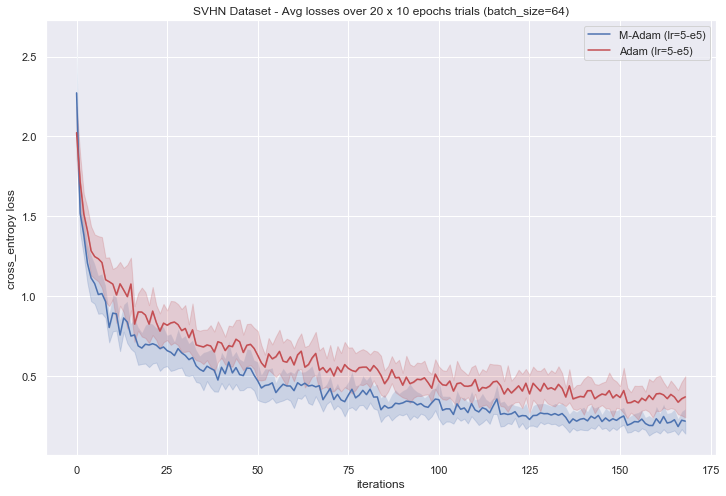

In [230]:
#adamax = adamax_cifar10
#adam = adam_cifar10
start = 1
plt.figure(figsize=(12,8))
plt.plot(madam.mean(axis=1)[start:], 'b')
plt.fill_between(np.arange(len(madam.mean(axis=1)[start:])), madam.mean(axis=1)[start:], madam.mean(axis=1)[start:] + madam.std(axis=1)[start:], alpha=0.2)
plt.fill_between(np.arange(len(madam.mean(axis=1)[start:])), madam.mean(axis=1)[start:], madam.mean(axis=1)[start:] - madam.std(axis=1)[start:], alpha=0.2,color='b')


#plt.plot(adamax_costs.mean(axis=1)[1:] + adamax_costs.std(axis=1)[1:], 'b', alpha=0.2)

plt.plot(adam.mean(axis=1)[start:], 'r')
plt.fill_between(np.arange(len(adam.mean(axis=1)[start:])), adam.mean(axis=1)[start:], adam.mean(axis=1)[start:] + adam.std(axis=1)[start:], alpha=0.2,color='r')
plt.fill_between(np.arange(len(adam.mean(axis=1)[start:])), adam.mean(axis=1)[start:], adam.mean(axis=1)[start:] - adam.std(axis=1)[start:], alpha=0.2,color='r')
plt.legend(['M-Adam (lr=5-e5)', 'Adam (lr=5-e5)'])
plt.xlabel('iterations')
plt.ylabel('cross_entropy loss')
plt.title('SVHN Dataset - Avg losses over 20 x 10 epochs trials (batch_size=64)')



## Conclusions

- We have shown empirically that the M-Adam algorithm is quite effective and helps to speed up convergence substantially. The same principle could be applied to any optimization algorithm that uses momentum. 


### Similar results are obtained when using Dropout

In [5]:
trials = 20
losses = []
for t in range(trials):
    nn_madam_drop = NN_madam(size_h_layer=(X__.shape[1], 256,256, len(np.unique(y__))), 
                              activation_h='ReLU', activation_o='softmax', initialization='truncnorm',
                              l_rate= 0.0001, l_decay=0.95, bias= 1 , l2_reg= 0.0, dropout=(1, (0,0.5,0.5)),
                              optimizer=('madam',{'beta1':0.9, 'beta2':0.999}),
                              print_=1, plots=1)
    nn_madam_drop.train_nn(X__, y__, epochs= 5, batch_size=128, nr_shuffles=1, cval=None, grads_stopping=True)
    losses.append(nn_madam_drop.tr_batch_cost)

NameError: name 'NN_madam' is not defined

In [26]:
madam_mnist = losses.copy()

In [27]:
madam_costs = np.zeros((len(madam_mnist[0]), len(madam_mnist)))
for i in range(len(madam_mnist)):
    madam_costs[:,i] = madam_mnist[i]

### Adam testing on MNIST

In [6]:
trials = 20
losses = []
for t in range(trials):
    nn_adam_drop = NN_madam(size_h_layer=(X__.shape[1], 256,256, len(np.unique(y__))), 
                              activation_h='ReLU', activation_o='softmax', initialization='truncnorm',
                              l_rate= 0.0001, l_decay=0.95, bias= 1 , l2_reg= 0.0, dropout=(1, (0,0.5,0.5)),
                              optimizer=('adam',{'beta1':0.9, 'beta2':0.999}),
                              print_=1, plots=1)
    nn_adam_drop.train_nn(X__, y__, epochs= 5, batch_size=128, nr_shuffles=1, cval=None, grads_stopping=True)
    losses.append(nn_adam_drop.tr_batch_cost)

NameError: name 'NN_madam' is not defined

In [29]:
adam_mnist = losses.copy()

In [30]:
adam_costs = np.zeros((len(adam_mnist[0]), len(adam_mnist)))
for i in range(len(adam_mnist)):
    adam_costs[:,i] = adam_mnist[i]

### Results on MNIST with Dropout

In [39]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

Text(0.5, 1.0, 'MNIST with Dropout - Avg losses over 20 x 5 epochs trials (batch=128)')

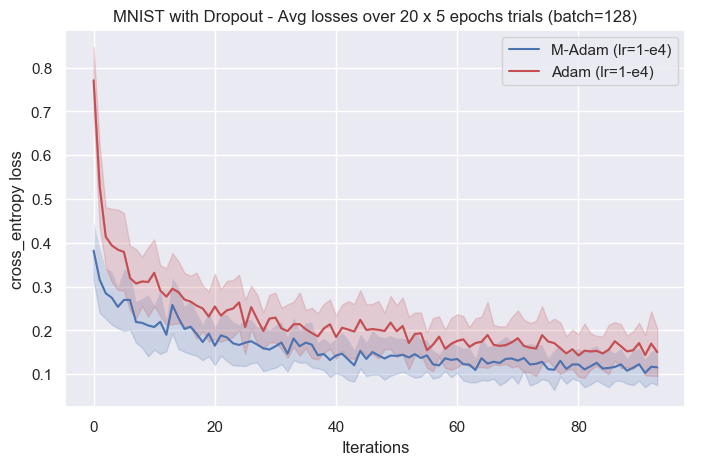

In [40]:
plt.figure(figsize=(8,5))
start = 1
plt.plot(madam_costs.mean(axis=1)[start:], 'b')
plt.fill_between(np.arange(len(madam_costs.mean(axis=1)[start:])), madam_costs.mean(axis=1)[start:], madam_costs.mean(axis=1)[start:] + madam_costs.std(axis=1)[start:], alpha=0.2)
plt.fill_between(np.arange(len(madam_costs.mean(axis=1)[start:])), madam_costs.mean(axis=1)[start:], madam_costs.mean(axis=1)[start:] - madam_costs.std(axis=1)[start:], alpha=0.2,color='b')


plt.plot(adam_costs.mean(axis=1)[1:], 'r')
plt.fill_between(np.arange(len(adam_costs.mean(axis=1)[start:])), adam_costs.mean(axis=1)[start:], adam_costs.mean(axis=1)[start:] + adam_costs.std(axis=1)[start:], alpha=0.2,color='r')
plt.fill_between(np.arange(len(adam_costs.mean(axis=1)[start:])), adam_costs.mean(axis=1)[start:], adam_costs.mean(axis=1)[start:] - adam_costs.std(axis=1)[start:], alpha=0.2,color='r')
plt.legend(['M-Adam (lr=1-e4)', 'Adam (lr=1-e4)'])
plt.xlabel('Iterations', size=12)
plt.ylabel('cross_entropy loss', size=12)
plt.title('MNIST with Dropout - Avg losses over 20 x 5 epochs trials (batch=128)', size=12)
